In [4]:
using Pkg
Pkg.instantiate()

In [5]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization, Chain, DataFramesMeta
using Statistics, FFTW, FindPeaks1D, LsqFit
import ColorSchemes as co 

In [6]:
image_data = "data//metrics"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  128_col_3_grow_3200_2024_03_20.csv
2  128_col_3_grow_3200_2024_03_20.jls
3  16_col_3_span_0.1_16002024_04_05.csv
4  16_col_3_span_0.1_16002024_04_05.jls
5  32_col_3_32002024_04_03.csv
6  32_col_3_32002024_04_03.jls
7  32_col_3_grow_type_22023_12_19.csv
8  32_col_3_grow_type_22023_12_19.jls
9  64_col_1_grow_4800_2024_03_15.csv
10  64_col_1_grow_4800_2024_03_15.jls
11  64_col_3_fixed_finger_growth_32002024_04_03.csv
12  64_col_3_fixed_finger_growth_32002024_04_03.jls
13  64_col_3_grow_1600_2024_03_27.csv
14  64_col_3_grow_1600_2024_03_27.jls
15  64_col_3_grow_32002024_03_08.csv
16  64_col_3_grow_32002024_03_08.jls
17  64_col_3_grow_type_22024_01_05.csv
18  64_col_3_grow_type_22024_01_05.jls
19  artifical_2023_09_14.jls
20  data_sets_10_2023-09-26.csv
21  data_sets_10_2023-09-26.jls


In [7]:
data_a = deserialize(joinpath(image_data,readdir(image_data)[4]))
first(data_a,2)

2×8 DataFrame
 Row │ data_set           colony              time   metric_OG                 ⋯
     │ String             String              Int64  Array…                    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Random 2024_04_05  Colony 1 artifical      0  [0, 0, 0, 0, 0, 0, 0, 0,  ⋯
   2 │ Random 2024_04_05  Colony 1 artifical      2  [4, 5, 3, 1, 3, 0, 0, 2,
                                                               5 columns omitted

In [8]:
data_r = deserialize(joinpath(image_data,readdir(image_data)[end]))
first(data_r,2)

2×8 DataFrame
 Row │ data_set                   colony         time   metric_cov             ⋯
     │ String                     String         Int64  Array…                 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 10_04_23_stacked_half_res  Kolonie 1.tif      0  [0, 0, 9, 6, 10, 7, 10 ⋯
   2 │ 10_04_23_stacked_half_res  Kolonie 1.tif     24  [0, 0, 1, 1, 0, 1, 1,
                                                               5 columns omitted

In [9]:
data_full = filter(row -> row.data_set[end-7:end] =="full_res", data_r )
unique(data_full.data_set)

4-element Vector{String}:
 "14_06_23_stacked_full_res"
 "17_05_23_stacked_full_res"
 "19_12_22_stacked_full_res"
 "26_06_23_stacked_full_res"

In [10]:
data_evo_all = filter(row -> row.data_set[end-12:end] =="full_res_expo", data_r )
unique(data_evo.data_set)
unique(data_evo_all.colony)

UndefVarError: UndefVarError: `data_evo` not defined

In [11]:
data_evo_active = filter(row -> row.colony =="Kolonie-1 seg manuell.tif" || row.colony == "Kolonie-4 seg manuell.tif", data_evo_all )
data_evo_passive = antijoin(data_evo_all, data_evo_active, on = :colony)
unique(data_evo_active.colony)

2-element Vector{String}:
 "Kolonie-1 seg manuell.tif"
 "Kolonie-4 seg manuell.tif"

In [12]:
path = "analysis\\comparison"
mkpath(path)

ana_para = analysis_parameters(plot_theme =
    Theme(  fontsize = 30,
    size = (1000,800),
    Scatter = (markersize = 18,
    label = "Real Colonies",),                
    Lines  = (linewidth =4,),
    Errorbars = (whiskerwidth = 20, 
    color = :black)
    ))
update_theme!(ana_para.plot_theme)

In [13]:
first(data_a,2) 

2×8 DataFrame
 Row │ data_set           colony              time   metric_OG                 ⋯
     │ String             String              Int64  Array…                    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Random 2024_04_05  Colony 1 artifical      0  [0, 0, 0, 0, 0, 0, 0, 0,  ⋯
   2 │ Random 2024_04_05  Colony 1 artifical      2  [4, 5, 3, 1, 3, 0, 0, 2,
                                                               5 columns omitted

In [14]:
pair_max_single = @chain data_a begin
    groupby([:time,:data_set])
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
    :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

pair_max_single_cov = @chain data_a begin
    groupby([:time,:data_set])
    @combine(:pair_cov = mean((maximum.(:pair_cov).-mean.(:pair_cov))./mean.(:pair_cov)),
    :pair_cov_stdd =std((maximum.(:pair_cov).-mean.(:pair_cov))./mean.(:pair_cov)) )
end

first(pair_max_single, 3)

pair_max_r = @chain data_full begin
    groupby(:time)
     @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

pair_max_evo_active = @chain data_evo_active begin
    groupby(:time)
     @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

pair_max_evo_passive = @chain data_evo_passive begin
    groupby(:time)
     @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

4×3 DataFrame
 Row │ time   pair_og    pair_og_stdd 
     │ Int64  Float64    Float64      
─────┼────────────────────────────────
   1 │     0  0.0444181    0.00352592
   2 │    20  0.415752     0.0437417
   3 │    24  0.46945      0.0607847
   4 │    44  0.522472     0.103532

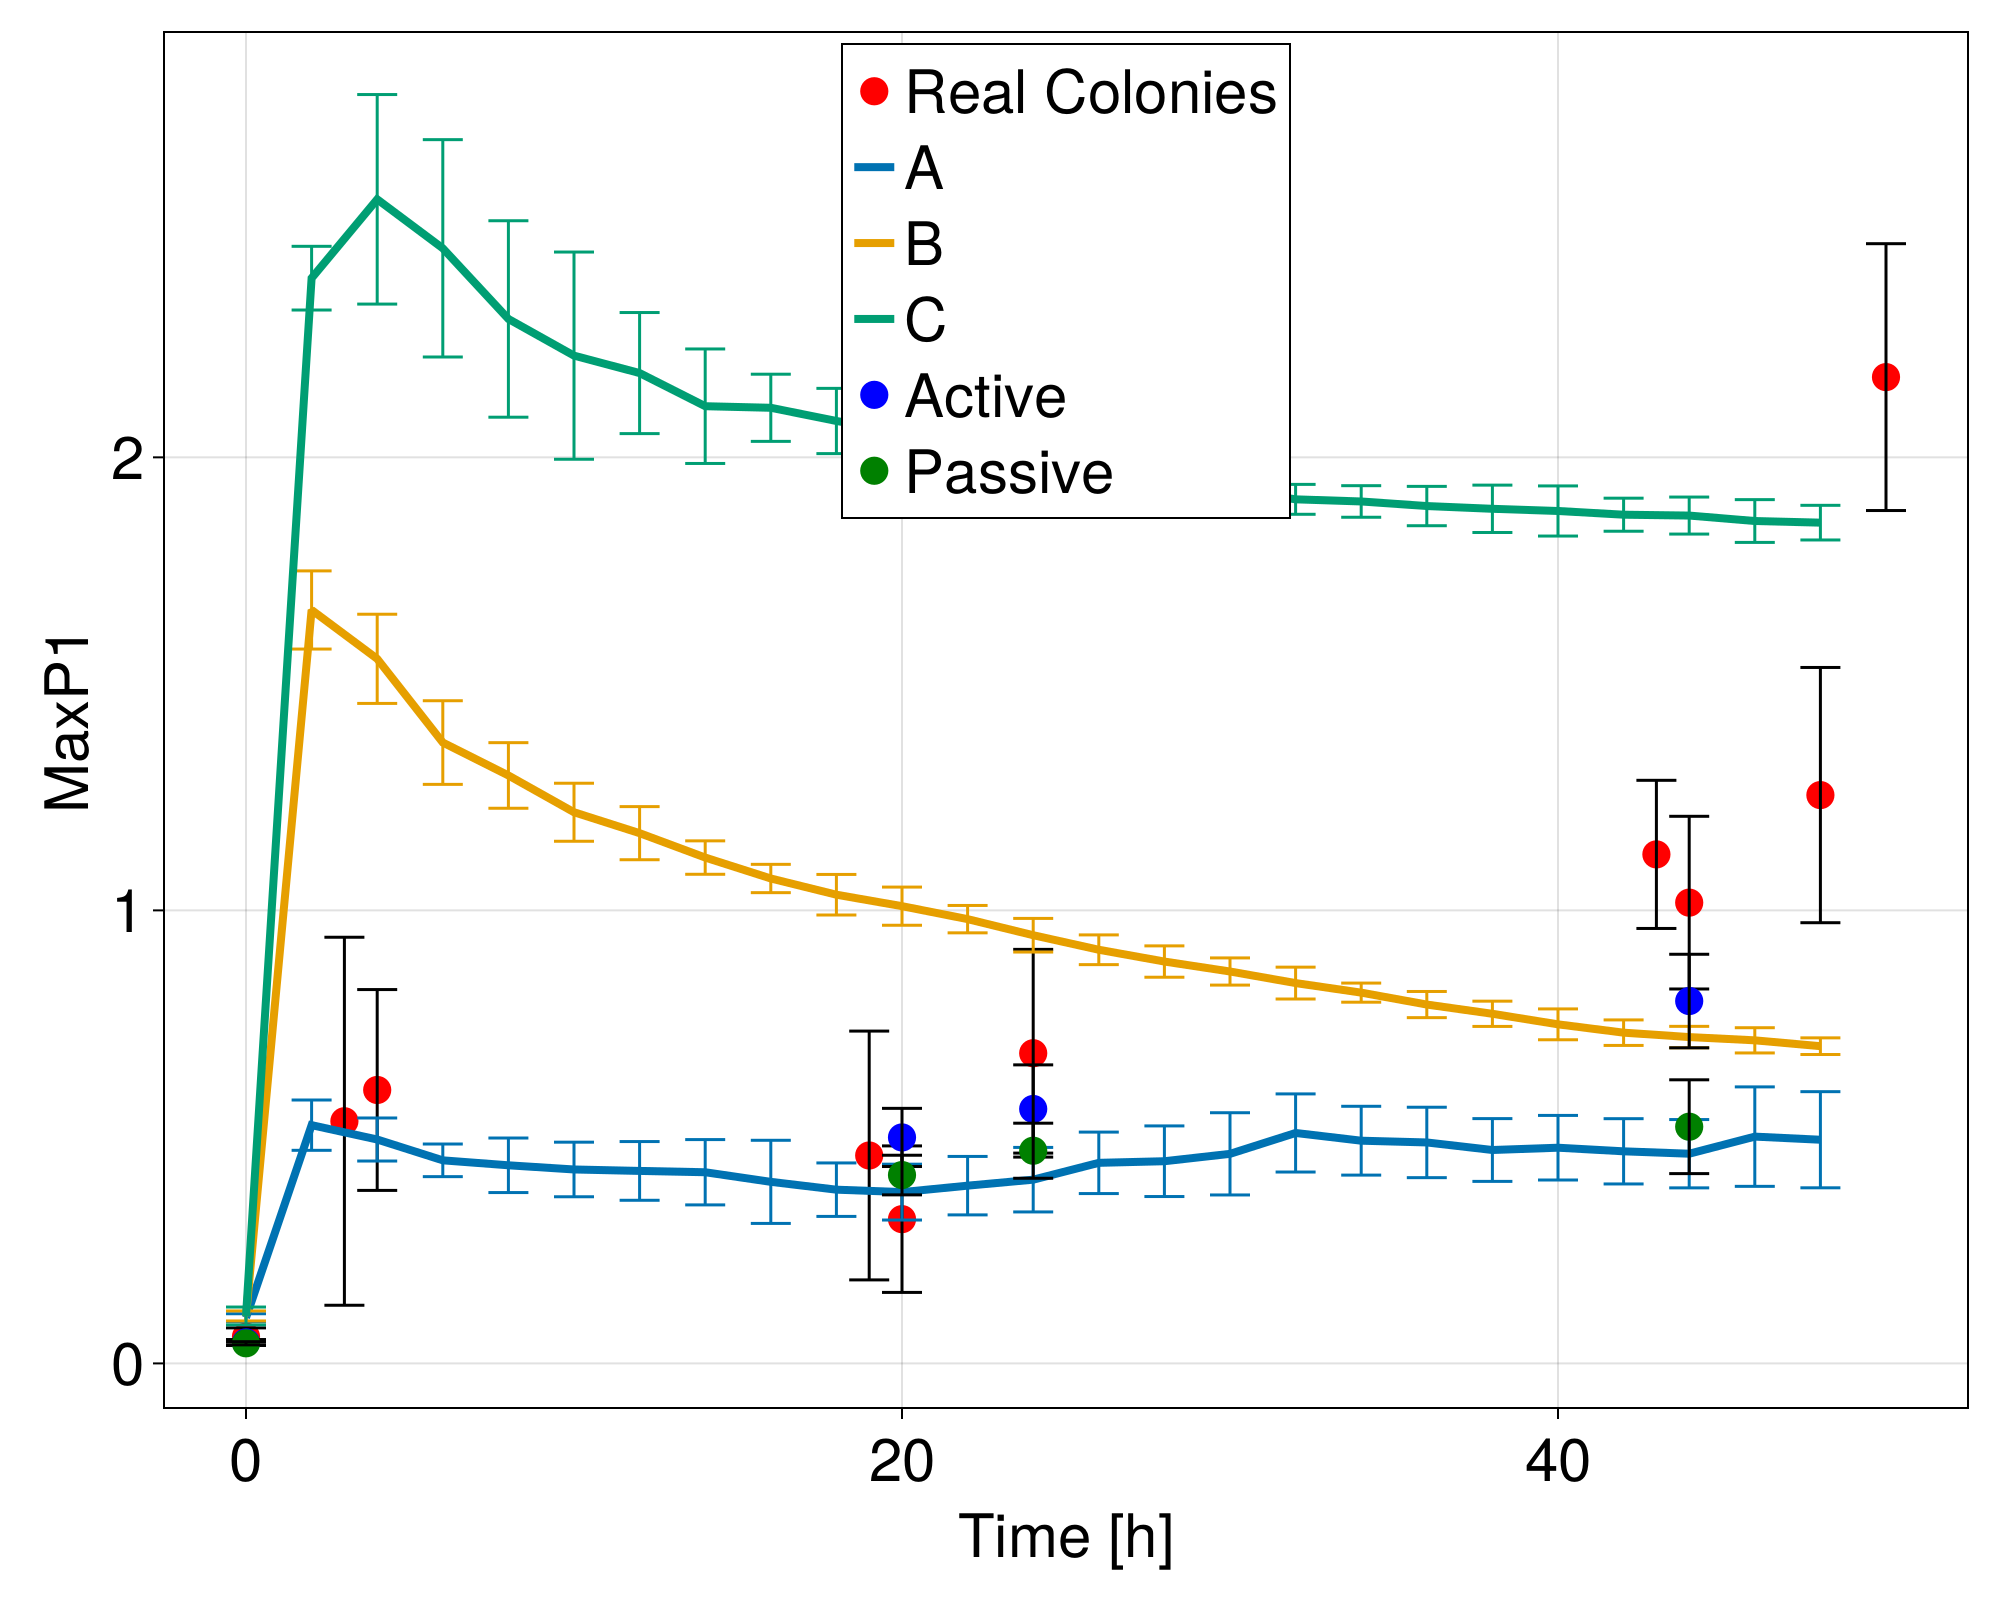

In [15]:
model_name = ["A","B","C"]
fig1 = Figure()
ax = CairoMakie.Axis(fig1[1,1])
scatter!(ax,pair_max_r.time,pair_max_r.pair_og, markersize = 20, color = "red")
errorbars!(ax,pair_max_r.time,pair_max_r.pair_og, pair_max_r.pair_og_stdd,whiskerwidth = 20, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="MaxP1"
j = 1
for (k, i) in pairs(groupby(pair_max_single_cov,:data_set))
    #lines!(ax, i.time, i.pair_og, label = mk_label(k.data_set),linewidth = 4)
    lines!(ax, i.time, i.pair_cov, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.pair_cov,i.pair_cov_stdd )
    j += 1
end

"""
j = 1
for (k, i) in pairs(groupby(pair_max_single,:data_set))
    #lines!(ax, i.time, i.pair_og, label = mk_label(k.data_set),linewidth = 4)
    lines!(ax, i.time, i.pair_og, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end

"""

## evo active
scatter!(ax,pair_max_evo_active.time,pair_max_evo_active.pair_og, markersize = 20, color = "blue", label ="Active")
errorbars!(ax,pair_max_evo_active.time,pair_max_evo_active.pair_og, pair_max_evo_active.pair_og_stdd,whiskerwidth = 20, color = :black)

## evo passive

scatter!(ax,pair_max_evo_passive.time,pair_max_evo_passive.pair_og, markersize = 20, color = "green", label ="Passive")
errorbars!(ax,pair_max_evo_passive.time,pair_max_evo_passive.pair_og, pair_max_evo_passive.pair_og_stdd,whiskerwidth = 20, color = :black)

axislegend(ax, position = :ct)
save(joinpath(path,"Comparision_MaxP1_64.pdf"),fig1)
fig1

## Coefficent of variantion 

In [16]:
cv_angular_max = @chain data_a begin
    groupby(:time)
    @combine(:cv_angu = mean(std.(:metric_OG)./(mean.(:metric_OG))), :cv_angu_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end
first(cv_angular_max,3)

cv_angular_max_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:cv_angu = mean(std.(:metric_OG)./(mean.(:metric_OG))), :cv_angu_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end
first(cv_angular_max_single,3)

3×4 DataFrame
 Row │ time   data_set           cv_angu     cv_angu_std 
     │ Int64  String             Float64     Float64     
─────┼───────────────────────────────────────────────────
   1 │     0  Random 2024_04_05  NaN         NaN
   2 │     2  Random 2024_04_05    0.543139    0.0217637
   3 │     4  Random 2024_04_05    0.363615    0.0184369

In [17]:
cv_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:cv_OG = mean(std.(:metric_OG)./(mean.(:metric_OG))),:cv_OG_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end

cv_angular_max_evo_active = @chain data_evo_active begin
    groupby(:time)
    @combine(:cv_OG = mean(std.(:metric_OG)./(mean.(:metric_OG))),:cv_OG_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end

cv_angular_max_evo_passive = @chain data_evo_passive begin
    groupby(:time)
    @combine(:cv_OG = mean(std.(:metric_OG)./(mean.(:metric_OG))),:cv_OG_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end

4×3 DataFrame
 Row │ time   cv_OG       cv_OG_std   
     │ Int64  Float64     Float64     
─────┼────────────────────────────────
   1 │     0  NaN         NaN
   2 │    20    0.654702    0.0338063
   3 │    24    0.690078    0.0380488
   4 │    44    0.726073    0.0720773

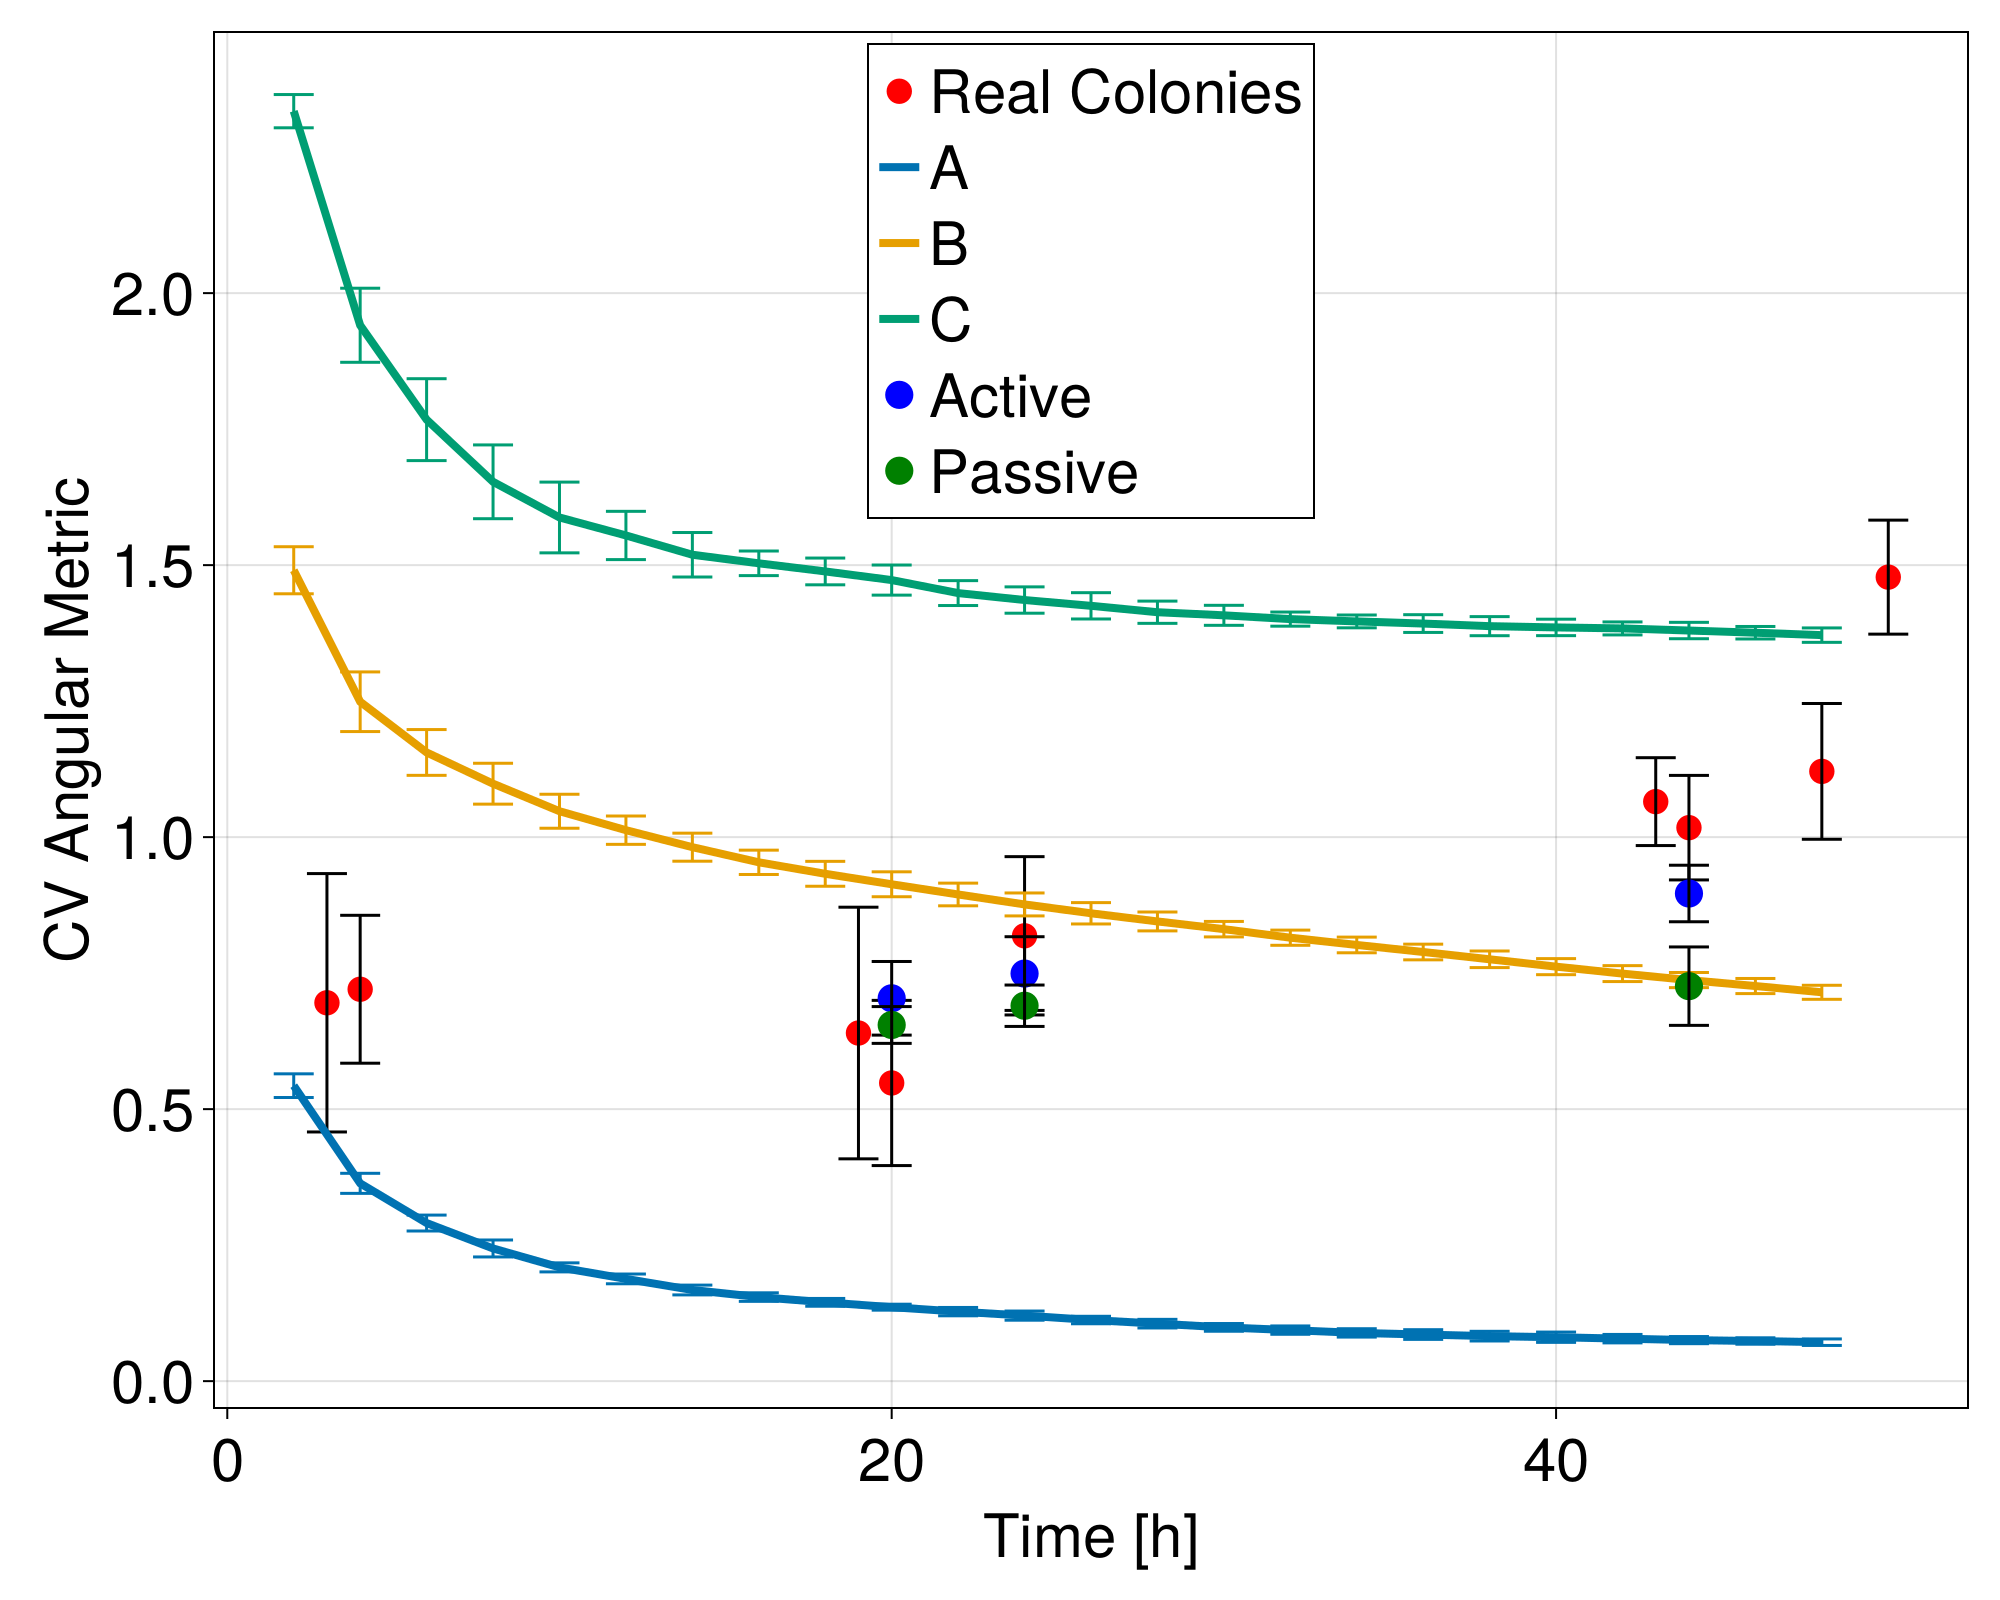

In [18]:
fig3 = Figure()
ax = CairoMakie.Axis(fig3[1,1])
scatter!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, color = :red)
errorbars!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, cv_angular_max_r.cv_OG_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="CV Angular Metric"
j = 1
for (k, i) in pairs(groupby(cv_angular_max_single,:data_set))
    #lines!(ax, i.time, i.cv_angu, label  = mk_label(k.data_set))
    lines!(ax,  i.time, i.cv_angu, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.cv_angu,i.cv_angu_std )
    j += 1
end

## evo active
scatter!(ax,cv_angular_max_evo_active.time,cv_angular_max_evo_active.cv_OG, markersize = 20, color = "blue", label ="Active")
errorbars!(ax,cv_angular_max_evo_active.time,cv_angular_max_evo_active.cv_OG, cv_angular_max_evo_active.cv_OG_std, color = :black)

## evo passive
scatter!(ax,cv_angular_max_evo_passive.time,cv_angular_max_evo_passive.cv_OG, markersize = 20, color = "green", label ="Passive")
errorbars!(ax,cv_angular_max_evo_passive.time,cv_angular_max_evo_passive.cv_OG, cv_angular_max_evo_passive.cv_OG_std, color = :black)

axislegend(ax, position = :ct)
save(joinpath(path,"Comparision_CV_64.pdf"),fig3)
fig3

## Root mean square fluctations/roughness

In [19]:
first(data_r,2)

2×8 DataFrame
 Row │ data_set                   colony         time   metric_cov             ⋯
     │ String                     String         Int64  Array…                 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 10_04_23_stacked_half_res  Kolonie 1.tif      0  [0, 0, 9, 6, 10, 7, 10 ⋯
   2 │ 10_04_23_stacked_half_res  Kolonie 1.tif     24  [0, 0, 1, 1, 0, 1, 1,
                                                               5 columns omitted

In [20]:
roughness_angular_max_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:roughness_angu = mean(std.(:metric_OG./:OG_size)),:roughness_angu_std = std(std.(:metric_OG./:OG_size)))
end
first(roughness_angular_max_single)

DataFrameRow
 Row │ time   data_set           roughness_angu  roughness_angu_std 
     │ Int64  String             Float64         Float64            
─────┼──────────────────────────────────────────────────────────────
   1 │     0  Random 2024_04_05             0.0                 0.0

In [21]:
roughness_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:roughness_OG = mean(std.(:metric_OG./:OG_size)),:roughness_OG_std = std(std.(:metric_OG)./:OG_size))
end

10×3 DataFrame
 Row │ time   roughness_OG  roughness_OG_std 
     │ Int64  Float64       Float64          
─────┼───────────────────────────────────────
   1 │     0   0.0               0.0
   2 │     3   0.000175816       0.000224939
   3 │     4   0.000195644       7.5901e-5
   4 │    19   0.00126122        0.000915271
   5 │    20   0.0015132         0.000485174
   6 │    24   0.00241562        0.000982732
   7 │    43   0.0064307         0.00174843
   8 │    44   0.00995087        0.00146493
   9 │    48   0.00899088        0.00256027
  10 │    50   0.013024          0.00145956

In [22]:
roughness_angular_right_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:roughness_angu = (mean(var.(:metric_OG./:OG_size, corrected = false)))^(1/2),:roughness_angu_std = (std(var.(:metric_OG./:OG_size, corrected = false)))^(1/2))
end
first(roughness_angular_right_single)

DataFrameRow
 Row │ time   data_set           roughness_angu  roughness_angu_std 
     │ Int64  String             Float64         Float64            
─────┼──────────────────────────────────────────────────────────────
   1 │     0  Random 2024_04_05             0.0                 0.0

In [23]:
roughness_angular_right = @chain data_full begin
    groupby([:time])
    @combine(:roughness_OG = (mean(var.(:metric_OG./:OG_size, corrected = false)))^(1/2),:roughness_OG_std = (std(var.(:metric_OG./:OG_size, corrected = false)))^(1/2))
end

roughness_angular_evo_active = @chain data_evo_active begin
    groupby(:time)
    @combine(:roughness_OG = mean(std.(:metric_OG./:OG_size)),:roughness_OG_std = std(std.(:metric_OG)./:OG_size))
end

roughness_angular_evo_passive = @chain data_evo_passive begin
    groupby(:time)
    @combine(:roughness_OG = mean(std.(:metric_OG./:OG_size)),:roughness_OG_std = std(std.(:metric_OG)./:OG_size))
end

4×3 DataFrame
 Row │ time   roughness_OG  roughness_OG_std 
     │ Int64  Float64       Float64          
─────┼───────────────────────────────────────
   1 │     0    0.0              0.0
   2 │    20    0.00639181       0.000221469
   3 │    24    0.00794533       0.000243663
   4 │    44    0.0125401        0.000404764

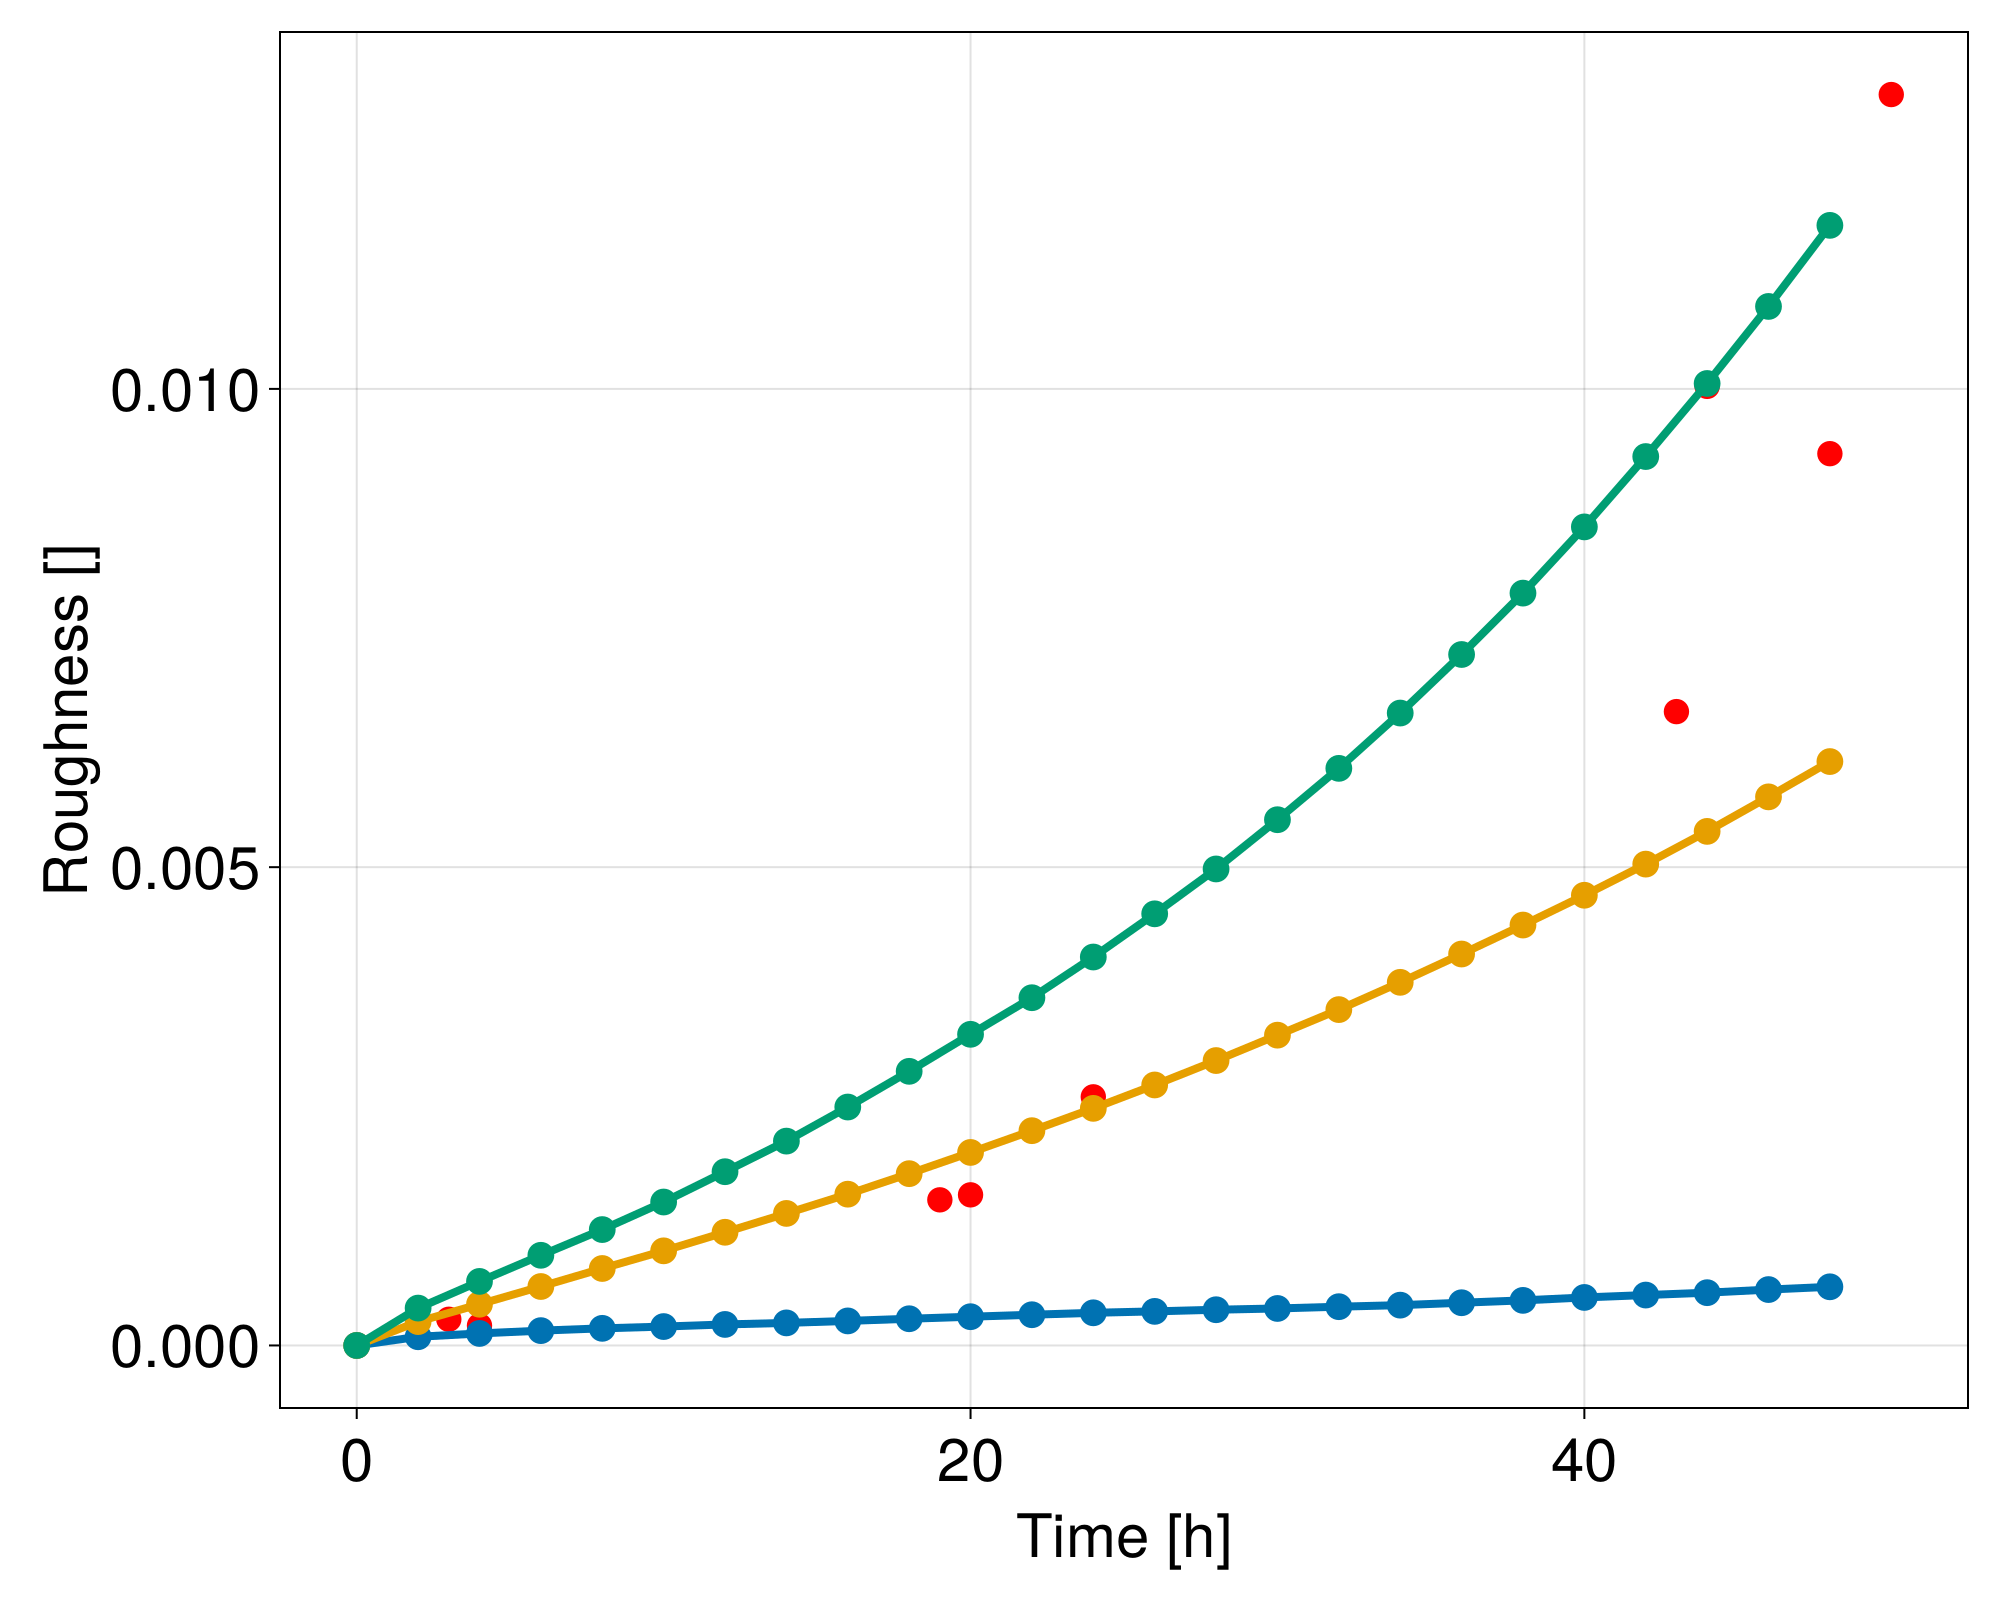

In [24]:
fig31 = Figure()
ax = CairoMakie.Axis(fig31[1,1])
scatter!(ax,roughness_angular_right.time,roughness_angular_right.roughness_OG, color = "red")
#errorbars!(ax,roughness_angular_right.time,roughness_angular_right.roughness_OG, roughness_angular_right.roughness_OG_std,color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Roughness []"
j = 1
for (k, i) in pairs(groupby(roughness_angular_right_single,:data_set))
    #lines!(ax, i.time, i.roughness_angu, label = mk_label(k.data_set))
    scatterlines!(ax, i.time, i.roughness_angu, label = model_name[j],linewidth = 4,markersize  = 19)
    #errorbars!(ax, i.time, i.roughness_angu,i.roughness_angu_std )
    j += 1
end
"""
## evo active 
scatter!(ax,roughness_angular_evo_active.time,roughness_angular_evo_active.roughness_OG, markersize = 20, color = "blue", label ="Active")
errorbars!(ax,roughness_angular_evo_active.time,roughness_angular_evo_active.roughness_OG, roughness_angular_evo_active.roughness_OG_std, color = :black)

## evo passive
scatter!(ax,roughness_angular_evo_passive.time,roughness_angular_evo_passive.roughness_OG, markersize = 20, color = "green", label ="Passive")
errorbars!(ax,roughness_angular_evo_passive.time,roughness_angular_evo_passive.roughness_OG, roughness_angular_evo_passive.roughness_OG_std, color = :black)
"""
axislegend(ax, position= :lt)
save(joinpath(path,"Comparision_interface_width.pdf"),fig31)
fig31

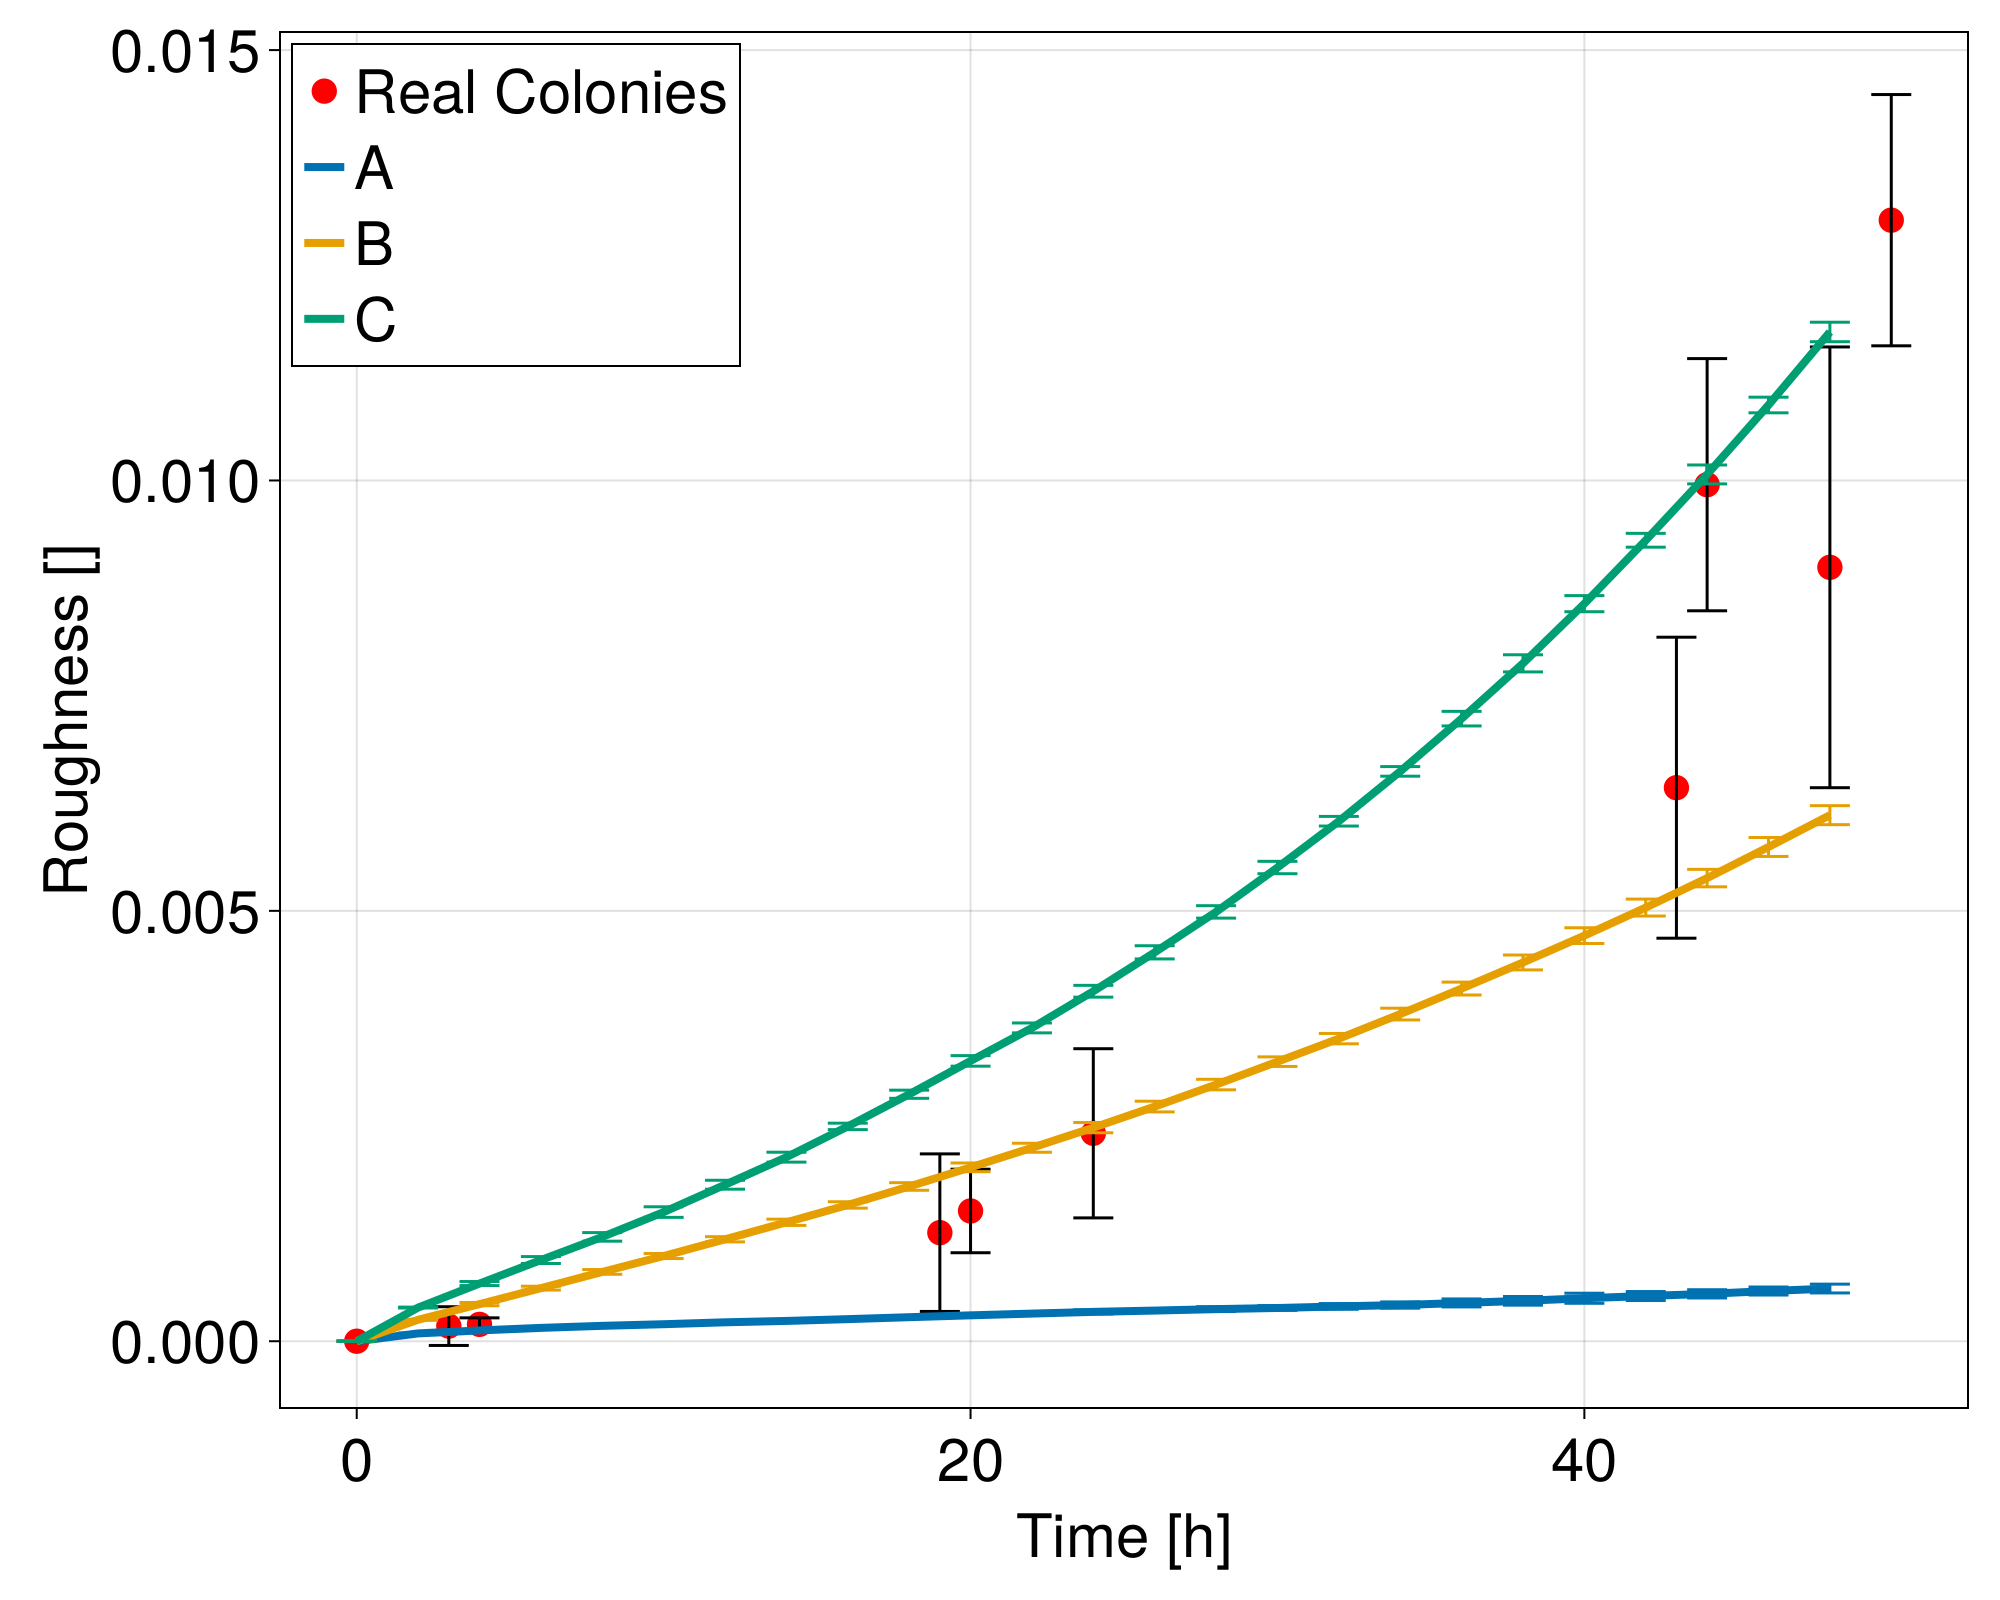

In [25]:
fig30 = Figure()
ax = CairoMakie.Axis(fig30[1,1])
scatter!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, color = "red")
errorbars!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, roughness_angular_max_r.roughness_OG_std,color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Roughness []"
j = 1
for (k, i) in pairs(groupby(roughness_angular_max_single,:data_set))
    #lines!(ax, i.time, i.roughness_angu, label = mk_label(k.data_set))
    lines!(ax, i.time, i.roughness_angu, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.roughness_angu,i.roughness_angu_std )
    j += 1
end
axislegend(ax, position= :lt)
save(joinpath(path,"Comparision_RMS_64.pdf"),fig30)
fig30

## Fourier Transform on data set 

In [26]:
fft_data = @chain data_a begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data)

fft_data_all = @chain data_a begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[1:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[1:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end

fft_data_first = @chain data_a begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[1]) for x in :fourier_conv], :abs_OG = [abs.(x[1]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data)

fft_data_r = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end

fft_data_r_all = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[1:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[1:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end


fft_data_r_first = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[1]) for x in :fourier_conv], :abs_OG = [abs.(x[1]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data_r_first)

fft_data_evo_active = @chain data_evo_active begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end

fft_data_evo_passive = @chain data_evo_passive begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end


16×14 DataFrame
 Row │ data_set                        colony                     time   metri ⋯
     │ String                          String                     Int64  Array ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 27_04_22_stacked_full_res_expo  Kolonie-2 seg manuell.tif      0  [26,  ⋯
   2 │ 27_04_22_stacked_full_res_expo  Kolonie-2 seg manuell.tif     20  [101,
   3 │ 27_04_22_stacked_full_res_expo  Kolonie-2 seg manuell.tif     24  [99,
   4 │ 27_04_22_stacked_full_res_expo  Kolonie-2 seg manuell.tif     44  [462,
   5 │ 27_04_22_stacked_full_res_expo  Kolonie-3 seg manuell.tif      0  [25,  ⋯
   6 │ 27_04_22_stacked_full_res_expo  Kolonie-3 seg manuell.tif     20  [447,
   7 │ 27_04_22_stacked_full_res_expo  Kolonie-3 seg manuell.tif     24  [578,
   8 │ 27_04_22_stacked_full_res_expo  Kolonie-3 seg manuell.tif     44  [726,
   9 │ 27_04_22_stacked_full_res_expo  Kolonie-5 seg manuell.tif      0  [27,  ⋯
  10 │ 27_04_22_stacked_full_res_expo  Kolonie-5 seg manuell.tif     20  [496,
  11 │ 27_04_22_stacked_full_res_expo  Kolonie-5 seg manuell.tif     24  [751,
  12 │ 27_04_22_stacked_full_res_expo  Kolonie-5 seg manuell.tif     44  [1866
  13 │ 27_04_22_stacked_full_res_expo  Kolonie-6 seg manuell.tif      0  [30,  ⋯
  14 │ 27_04_22_stacked_full_res_expo  Kolonie-6 seg manuell.tif     20  [41,
  15 │ 27_04_22_stacked_full_res_expo  Kolonie-6 seg manuell.tif     24  [38,
  16 │ 27_04_22_stacked_full_res_expo  Kolonie-6 seg manuell.tif     44  [47,
                                                              11 columns omitted

In [27]:
abs_fftw = @chain fft_data begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n))
    ,:abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end
first(abs_fftw,3)

abs_fftw_single = @chain fft_data begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),
    :abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end
last(abs_fftw_single,3)

3×10 DataFrame
 Row │ time   data_set                  abs_og     abs_cov    abs_og_n  abs_co ⋯
     │ Int64  String                    Float64    Float64    Float64   Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    44  Finger_strong 2024_04_05  2.30132e5  2.29338e5   11.1774    11.1 ⋯
   2 │    46  Finger_strong 2024_04_05  2.44403e5  2.43635e5   11.8705    11.8
   3 │    48  Finger_strong 2024_04_05  2.65718e5  2.64934e5   12.9058    12.8
                                                               5 columns omitted

In [28]:
abs_fftw_all = @chain fft_data_all begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n))
    ,:abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end
first(abs_fftw,3)

abs_fftw_single_all = @chain fft_data_all begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),
    :abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end

last(abs_fftw_single_all,3)

3×10 DataFrame
 Row │ time   data_set                  abs_og     abs_cov         abs_og_n  a ⋯
     │ Int64  String                    Float64    Float64         Float64   F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    44  Finger_strong 2024_04_05  2.84227e5       2.8356e5    13.8048    ⋯
   2 │    46  Finger_strong 2024_04_05  3.03003e5       3.02361e5   14.7167
   3 │    48  Finger_strong 2024_04_05  3.29094e5  328436.0         15.984
                                                               5 columns omitted

In [29]:
abs_fftw_all_first = @chain fft_data_first begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n))
    ,:abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end
first(abs_fftw,3)

abs_fftw_single_all_first = @chain fft_data_first begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),
    :abs_og_std = std(sum.(:abs_OG)), :abs_cov_std = std(sum.(:abs_cov)),:abs_og_n_std = std(sum.(:abs_OG_n)),:abs_cov_n_std = std(sum.(:abs_cov_n)))
end

last(abs_fftw_single_all,3)

3×10 DataFrame
 Row │ time   data_set                  abs_og     abs_cov         abs_og_n  a ⋯
     │ Int64  String                    Float64    Float64         Float64   F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    44  Finger_strong 2024_04_05  2.84227e5       2.8356e5    13.8048    ⋯
   2 │    46  Finger_strong 2024_04_05  3.03003e5       3.02361e5   14.7167
   3 │    48  Finger_strong 2024_04_05  3.29094e5  328436.0         15.984
                                                               5 columns omitted

In [30]:
abs_fftw_r_first = @chain fft_data_r_first begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end
last(abs_fftw_r_all,5)

UndefVarError: UndefVarError: `abs_fftw_r_all` not defined

In [31]:
abs_fftw_r_all = @chain fft_data_r_all begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end
last(abs_fftw_r_all,5)

5×6 DataFrame
 Row │ time   abs_og     abs_cov        abs_og_n  abs_cov_n  abs_og_n_std 
     │ Int64  Float64    Float64        Float64   Float64    Float64      
─────┼────────────────────────────────────────────────────────────────────
   1 │    24  1.05275e5  98447.7         5.23896     4.9021       2.06074
   2 │    43  3.79381e5      3.67919e5  13.4943     13.0836       4.25813
   3 │    44  3.1484e5       3.03466e5  20.6009     19.8613       3.44611
   4 │    48  3.92854e5      3.84029e5  19.0877     18.6851       5.80726
   5 │    50  4.19777e5      4.12892e5  24.9564     24.5467       3.08023

In [32]:
abs_fftw_r = @chain fft_data_r begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end
last(abs_fftw_r,5)

abs_fftw_evo_active = @chain fft_data_evo_active begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end

abs_fftw_evo_passive = @chain fft_data_evo_passive begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end

4×6 DataFrame
 Row │ time   abs_og     abs_cov        abs_og_n  abs_cov_n  abs_og_n_std 
     │ Int64  Float64    Float64        Float64   Float64    Float64      
─────┼────────────────────────────────────────────────────────────────────
   1 │     0  0.0        41742.3          0.0      0.660236       0.0
   2 │    20  7.6595e5       7.38138e5   12.1193  11.68           1.02
   3 │    24  9.45085e5      9.20929e5   14.9551  14.5739         1.35614
   4 │    44  1.49323e6      1.47788e6   23.6334  23.3915         3.10522

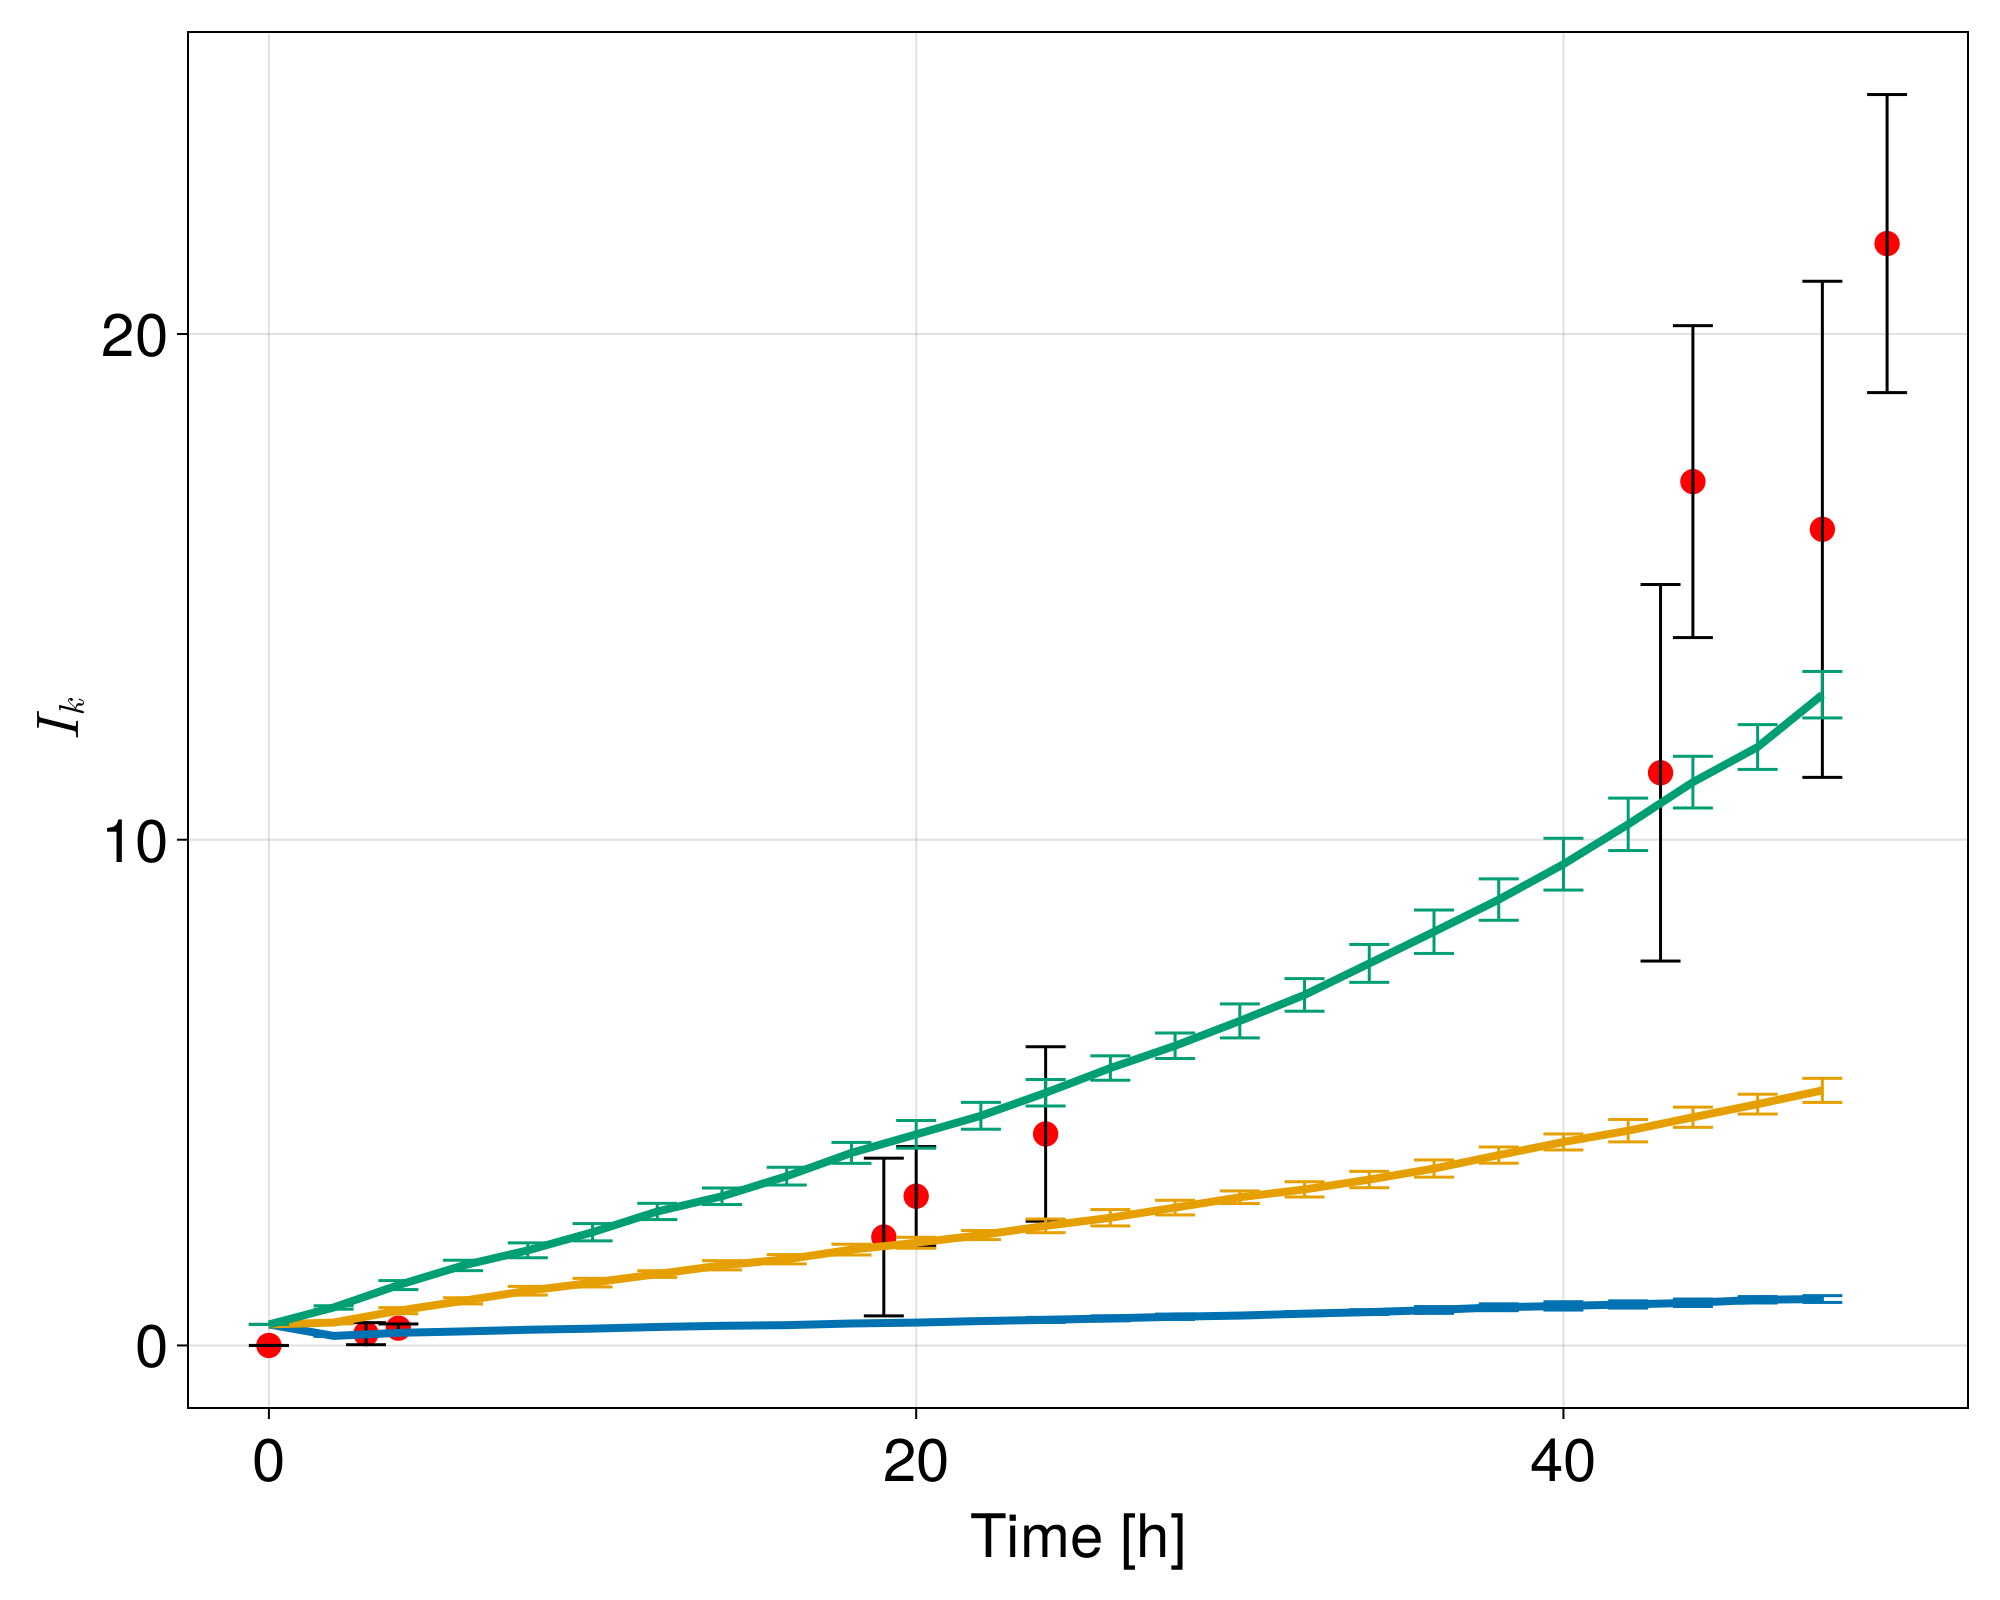

In [33]:
fig5 = Figure()
ax = CairoMakie.Axis(fig5[1,1])
scatter!(ax,abs_fftw_r.time, abs_fftw_r.abs_og_n, color = "red") 
errorbars!(ax, abs_fftw_r.time, abs_fftw_r.abs_og_n , abs_fftw_r.abs_og_n_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel = L"I_{k}"
j = 1
for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    #lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    lines!(ax, i.time, i.abs_cov_n, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.abs_cov_n,i.abs_og_n_std )
    j += 1
end
"""
## evo active
scatter!(ax,abs_fftw_evo_active.time, abs_fftw_evo_active.abs_og_n, markersize = 20, color = "blue", label ="Active")
errorbars!(ax,abs_fftw_evo_active.time, abs_fftw_evo_active.abs_og_n, abs_fftw_evo_active.abs_og_n_std, color = :black)

## evo passive
scatter!(ax,abs_fftw_evo_passive.time, abs_fftw_evo_passive.abs_og_n, markersize = 20, color = "green", label ="Passive")
errorbars!(ax,abs_fftw_evo_passive.time, abs_fftw_evo_passive.abs_og_n, abs_fftw_evo_passive.abs_og_n_std, color = :black)
"""
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_fourier_coeff_64.pdf"),fig5)
fig5

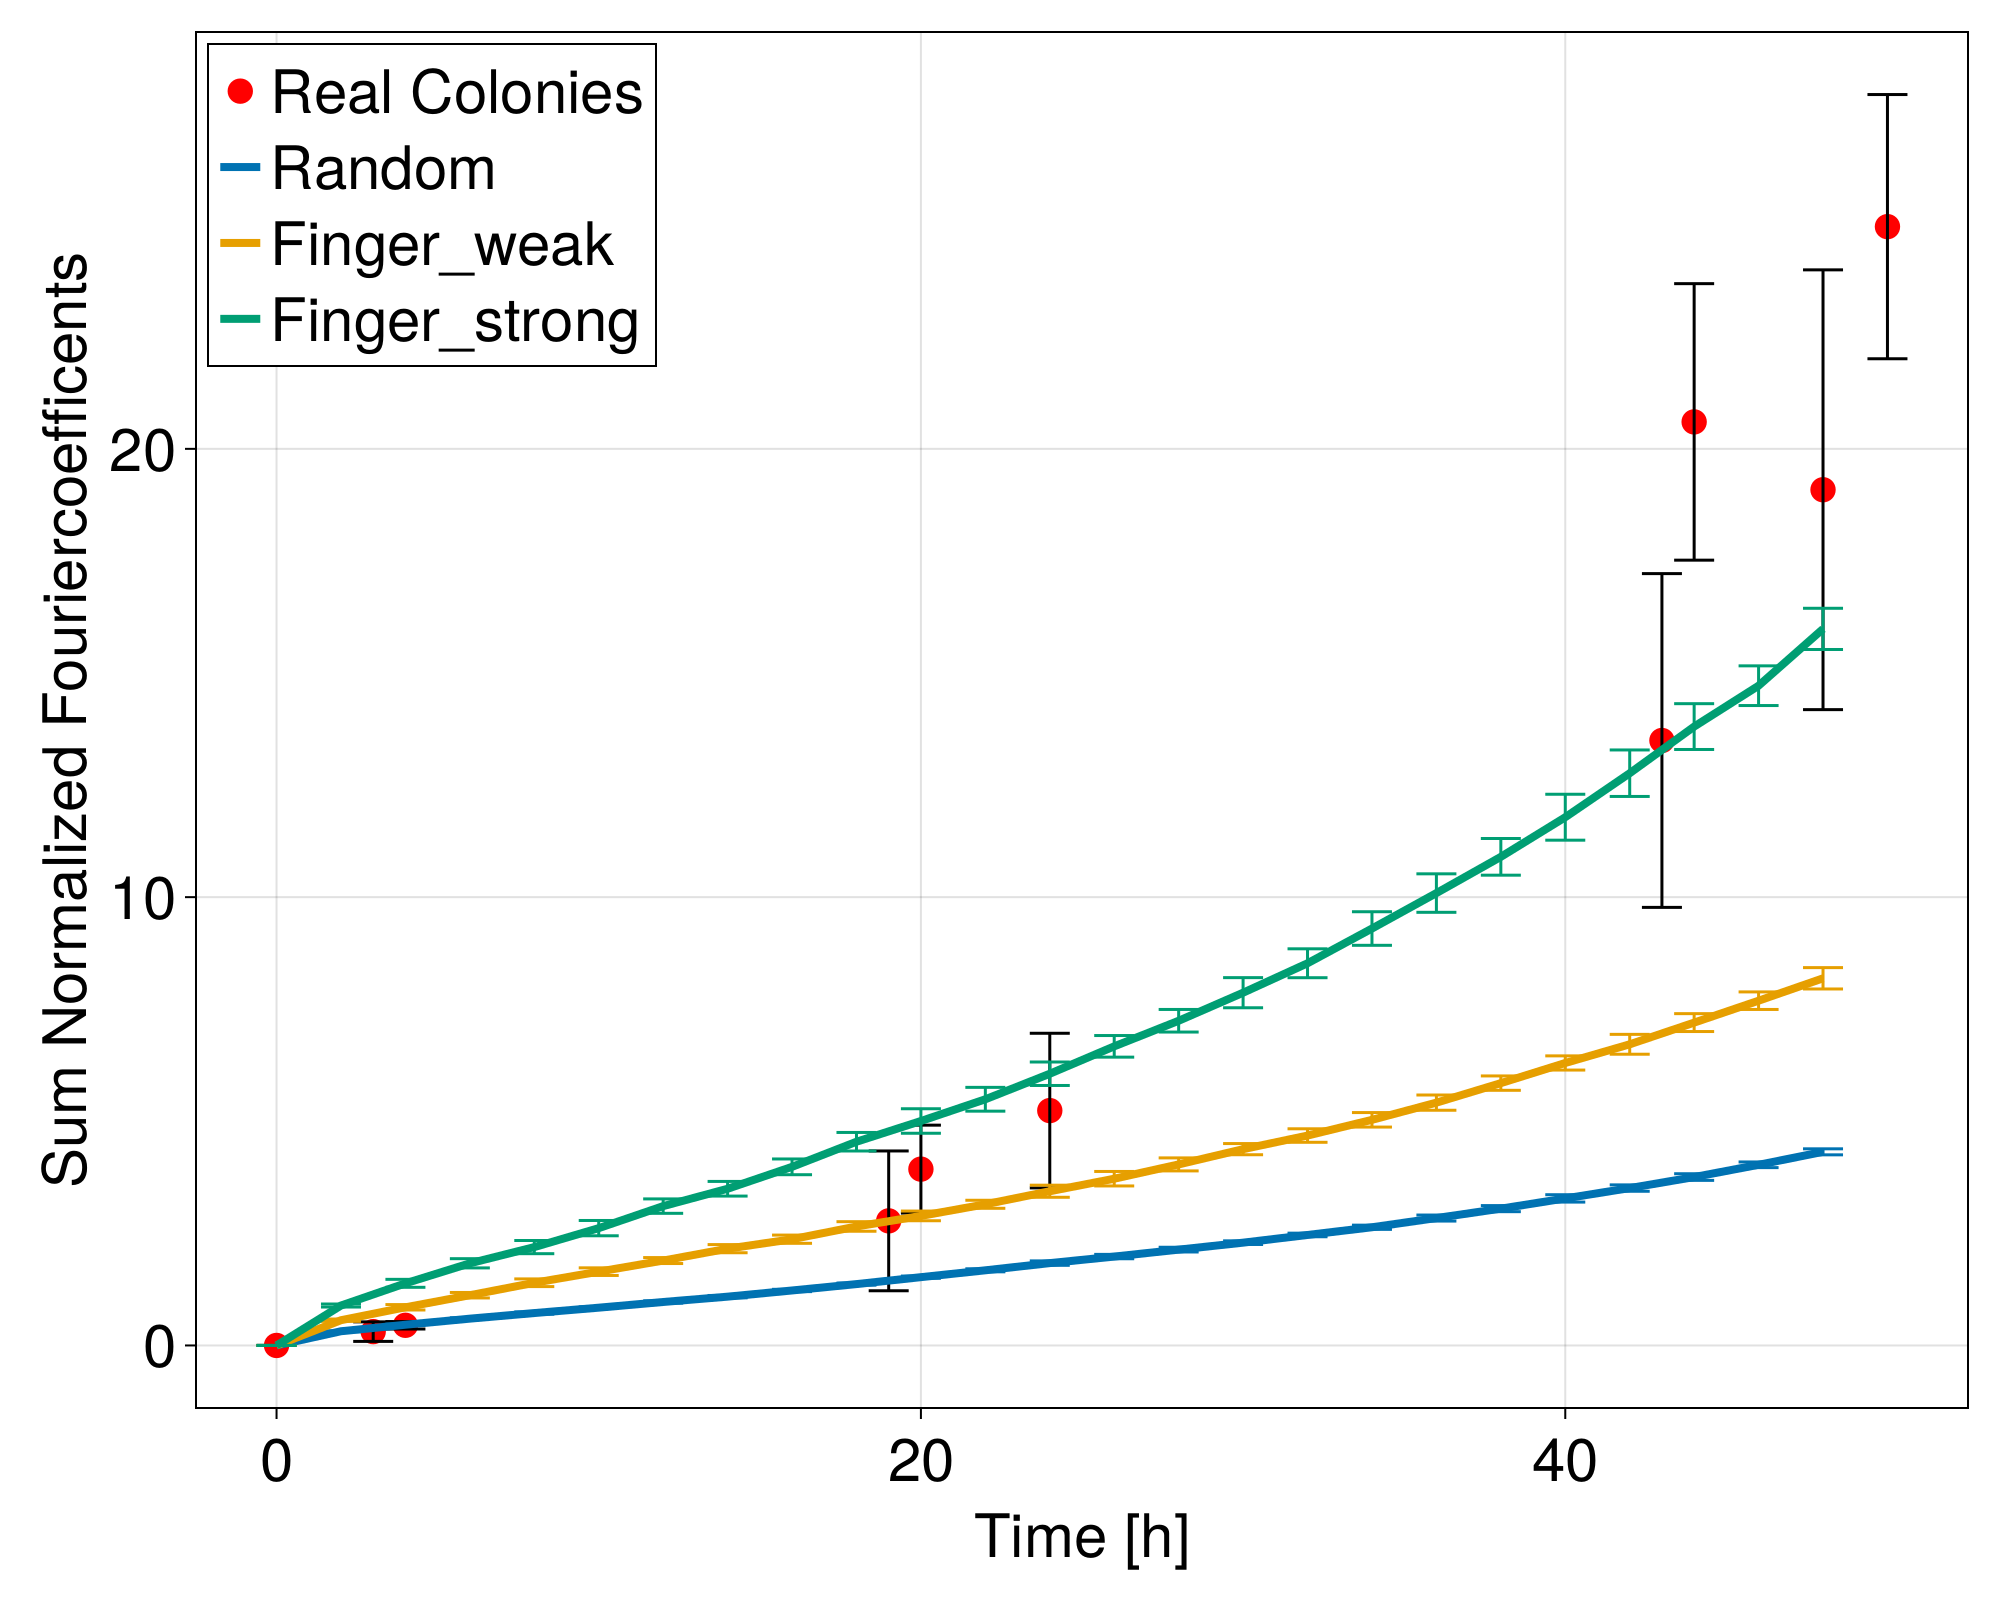

In [34]:
fig6 = Figure()
ax = CairoMakie.Axis(fig6[1,1])
scatter!(ax,abs_fftw_r_all.time, abs_fftw_r_all.abs_og_n, color = "red") 
errorbars!(ax, abs_fftw_r_all.time, abs_fftw_r_all.abs_og_n , abs_fftw_r.abs_og_n_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Sum Normalized Fouriercoefficents"
j = 1
for (k, i) in pairs(groupby(abs_fftw_single_all,:data_set))
    lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    errorbars!(ax, i.time, i.abs_og_n,i.abs_og_n_std )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_fourier_coeff_64_0.pdf"),fig6)
fig6

In [35]:
abs_fftw_single_all_first

75×10 DataFrame
 Row │ time   data_set                  abs_og    abs_cov    abs_og_n   abs_co ⋯
     │ Int64  String                    Float64   Float64    Float64    Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0  Random 2024_04_05             0.0   20589.0    0.0        1.0    ⋯
   2 │     2  Random 2024_04_05          1241.75    604.125  0.0603113  0.0293
   3 │     4  Random 2024_04_05          2559.31    881.562  0.124305   0.0428
   4 │     6  Random 2024_04_05          3954.81    971.125  0.192084   0.0471
   5 │     8  Random 2024_04_05          5435.0    1178.0    0.263976   0.0572 ⋯
   6 │    10  Random 2024_04_05          7005.06   1246.06   0.340233   0.0605
   7 │    12  Random 2024_04_05          8669.12   1445.31   0.421056   0.0701
   8 │    14  Random 2024_04_05         10434.2    1513.75   0.506785   0.0735
  ⋮  │   ⋮               ⋮                 ⋮          ⋮          ⋮          ⋮  ⋱
  69 │    36  Finger_strong 2024_04_05  38497.0   38628.0    1.86978    1.8761 ⋯
  70 │    38  Finger_strong 2024_04_05  42061.0   42191.3    2.04289    2.0492
  71 │    40  Finger_strong 2024_04_05  45840.0   45969.6    2.22643    2.2327
  72 │    42  Finger_strong 2024_04_05  49847.0   49975.9    2.42105    2.4273
  73 │    44  Finger_strong 2024_04_05  54095.0   54222.7    2.62737    2.6335 ⋯
  74 │    46  Finger_strong 2024_04_05  58600.0   58726.8    2.84618    2.8523
  75 │    48  Finger_strong 2024_04_05  63376.0   63501.7    3.07815    3.0842
                                                   5 columns and 60 rows omitted

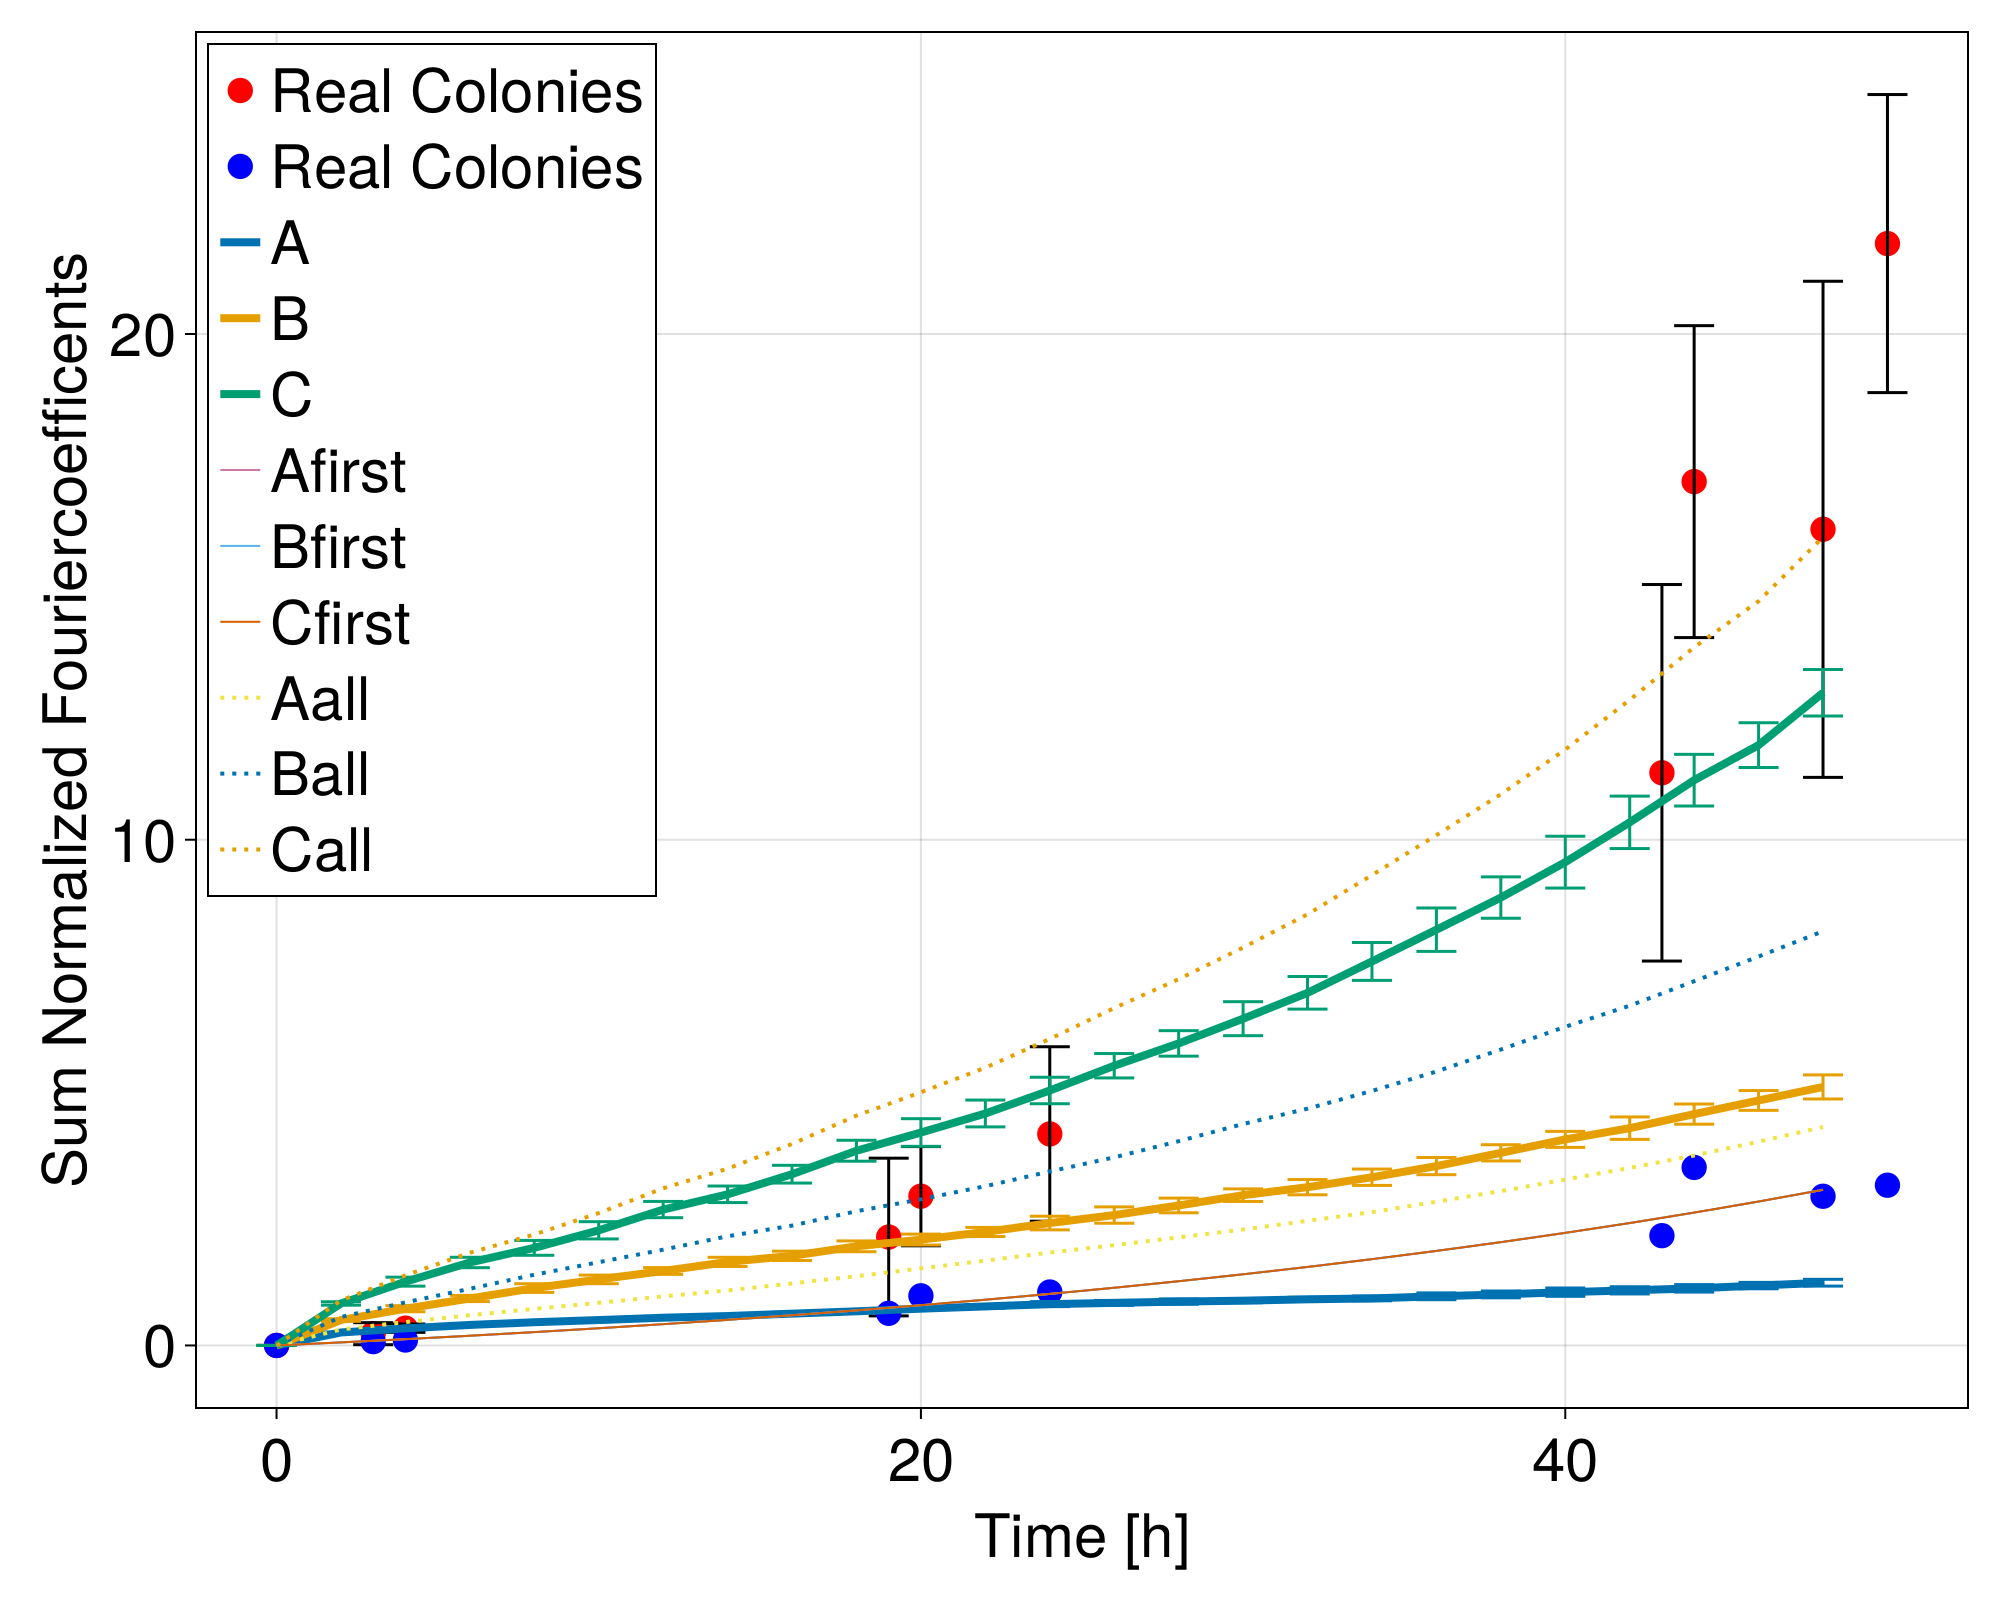

In [36]:
fig7 = Figure()
ax = CairoMakie.Axis(fig7[1,1])
scatter!(ax,abs_fftw_r.time, abs_fftw_r.abs_og_n, color = "red") 
errorbars!(ax, abs_fftw_r.time, abs_fftw_r.abs_og_n , abs_fftw_r.abs_og_n_std, color = :black)

scatter!(ax,abs_fftw_r_first.time, abs_fftw_r_first.abs_og_n, color = "blue") 

ax.xlabel ="Time [h]"
ax.ylabel ="Sum Normalized Fouriercoefficents"


j = 1
for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    #lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    lines!(ax, i.time, i.abs_og_n, label = model_name[j],linewidth = 4)
    errorbars!(ax, i.time, i.abs_og_n,i.abs_og_n_std )
    j += 1
end

j = 1
for (k, i) in pairs(groupby(abs_fftw_single_all_first,:data_set))
    #lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    lines!(ax, i.time, i.abs_og_n, label = model_name[j]*"first",linewidth = 1)
    #errorbars!(ax, i.time, i.abs_og_n,i.abs_og_n_std )
    j += 1
end


j = 1
for (k, i) in pairs(groupby(abs_fftw_single_all,:data_set))
    #lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    lines!(ax, i.time, i.abs_og_n, label = model_name[j]*"all",linewidth = 2, linestyle = :dot)
    #errorbars!(ax, i.time, i.abs_og_n,i.abs_og_n_std )
    j += 1
end

axislegend(ax, position = :lt)
save(joinpath(path,"Relation_fourier_coeff_64.pdf"),fig7)
fig7

In [37]:
all_frequ = vcat(filter_fourier_beta.(fft_data.abs_OG_n)...);

fft_data_r_old = @subset(fft_data_r, :time .> 10)
fft_data_a_old = @subset(fft_data, :time .> 10);

In [38]:
histo_data_r = vcat(find_freq.(filter_fourier_beta.(fft_data_r.abs_OG_n, b  =0.8))...);

histo_data_evo_active = vcat(find_freq.(filter_fourier_beta.(fft_data_evo_active.abs_OG_n, b  =0.8))...);
histo_data_evo_passive = vcat(find_freq.(filter_fourier_beta.(fft_data_evo_passive.abs_OG_n, b  =0.8))...);

In [39]:
median(histo_data_r)

13.0

In [40]:
histo_data_evo_active

3-element Vector{Int64}:
 21
 21
 21

In [41]:
mean(histo_data_r)


13.099137931034482

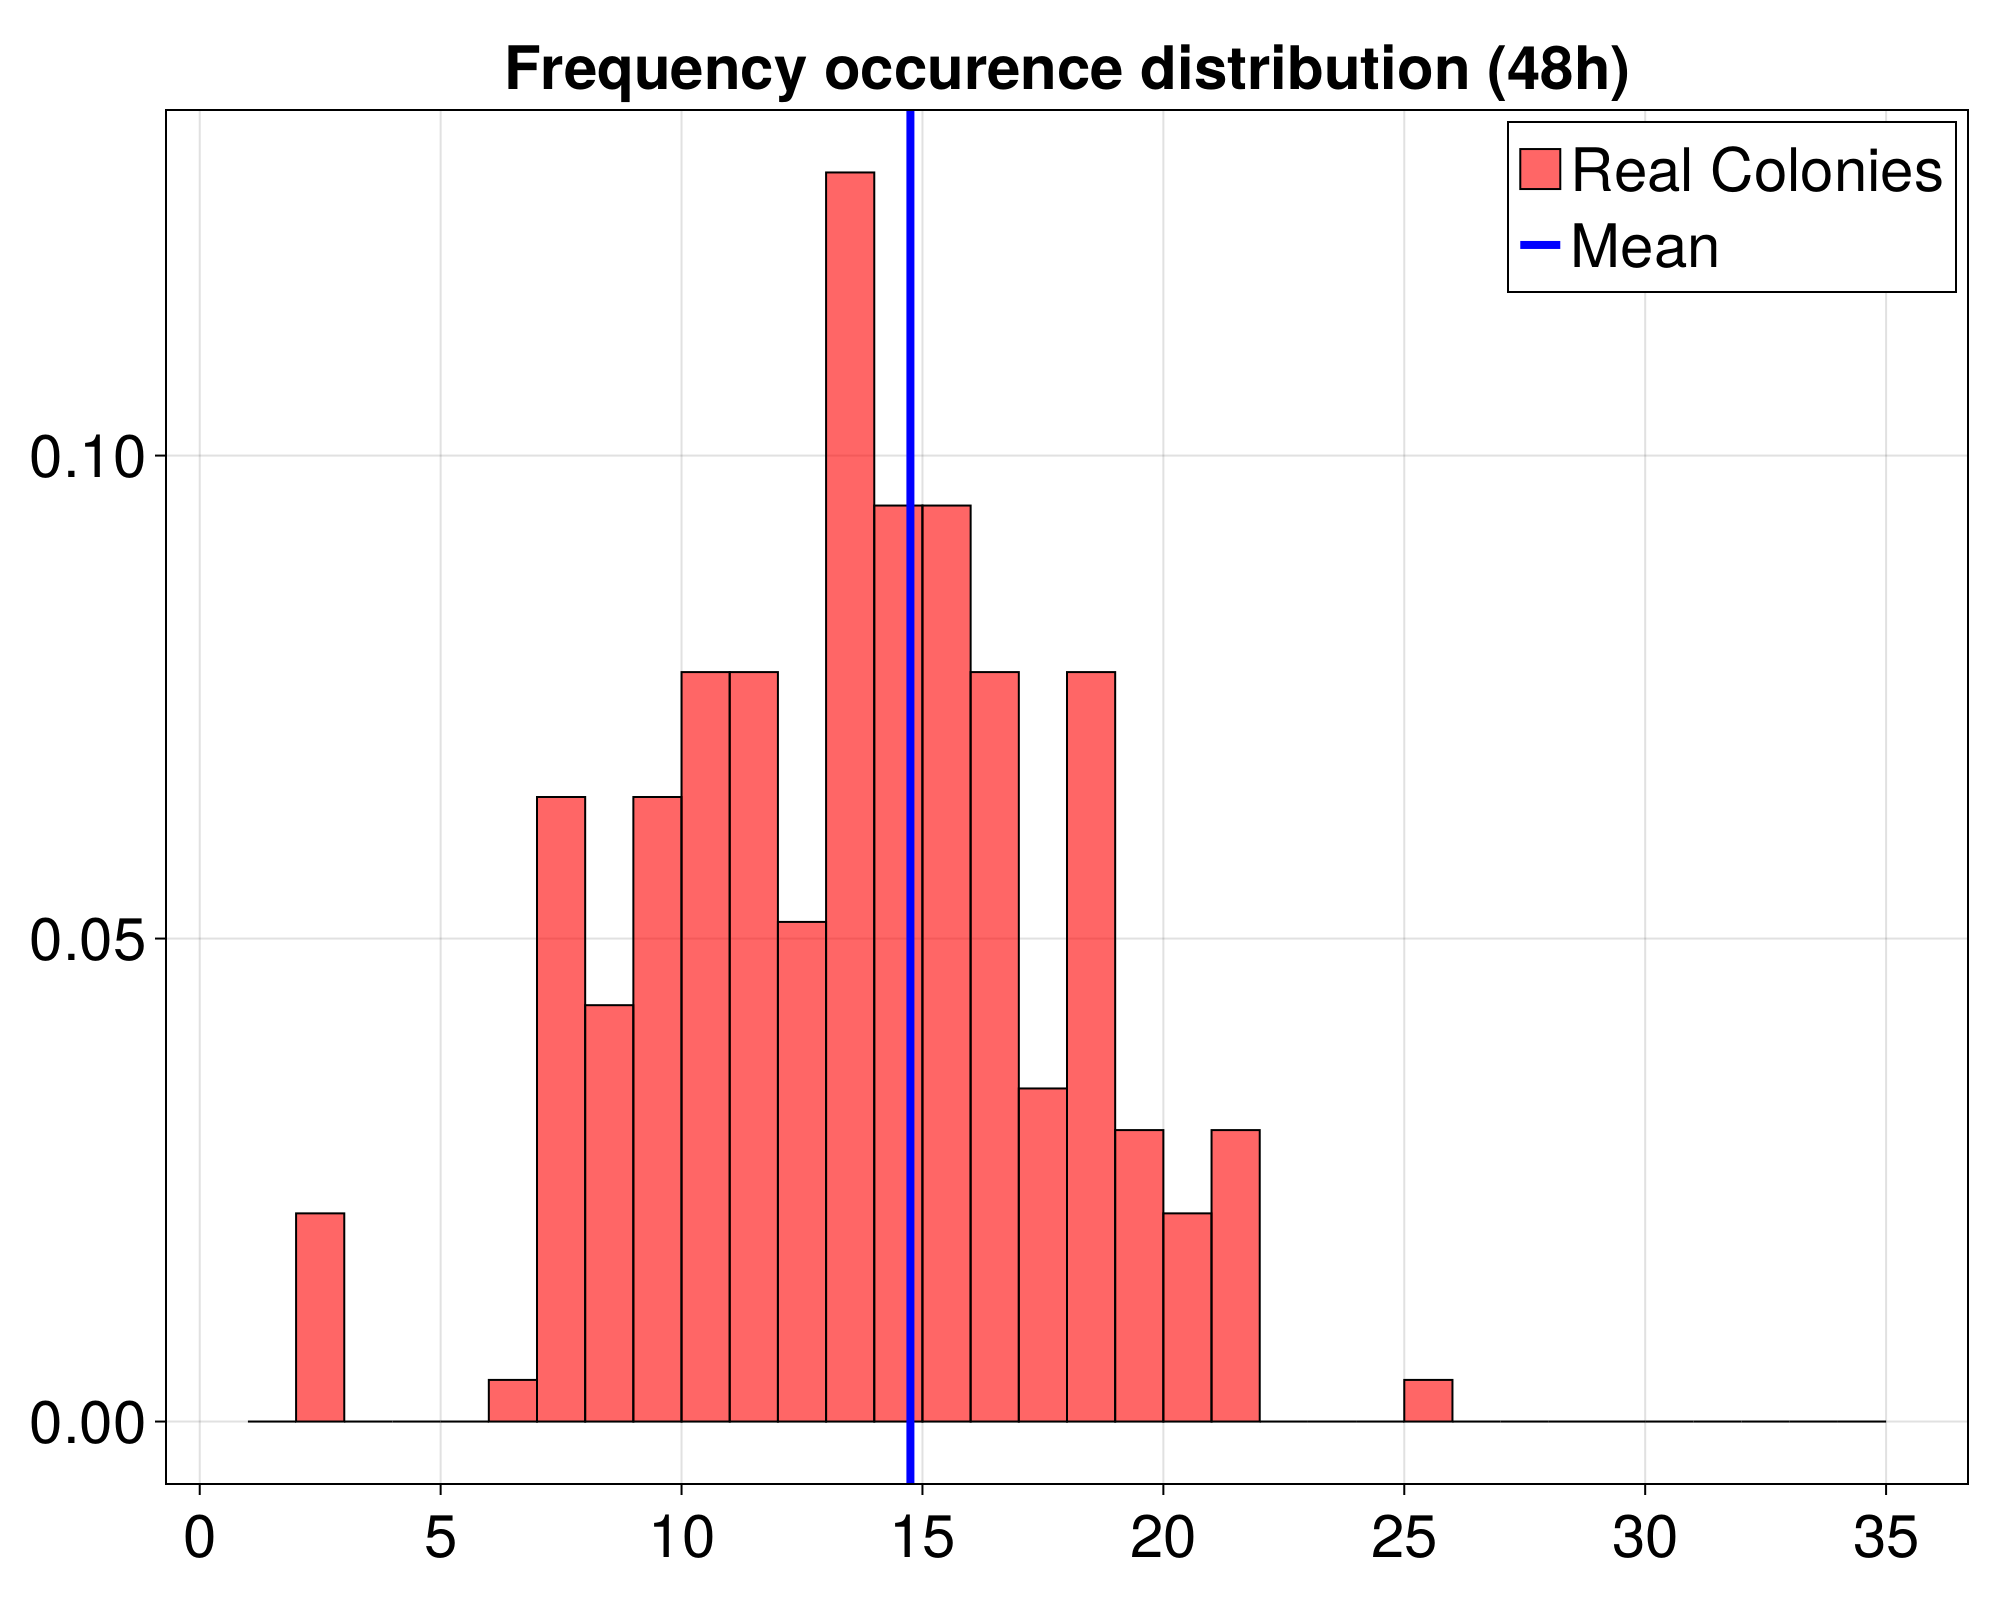

In [42]:
histo_data_a_vec = []
color_vec =[:green, :blue, :yellow, :orange, :purple, :black, :pink, :cyan, :magenta]



hans = Figure()
ax = Axis(hans[1,1])
#ylims!(ax,0,0.09)
histi = hist!(ax,histo_data_r, bins = 1:35,strokewidth = 1, color = (:red, 0.6), label = "Real Colonies",normalization = :pdf)
c = 1

"""
for (k,i) in pairs(groupby(fft_data_a_old,:data_set))
    push!(histo_data_a_vec, vcat(find_freq.(filter_fourier_beta.(i.abs_OG_n, b  =0.5))...))
    hist!(ax,histo_data_a_vec[end], bins = 1:40,strokewidth = 1, color = (color_vec[c], 0.3), label = mk_label(k.data_set),normalization = :pdf)
    c += 1
end
"""

vlines!(ax, 14.75, ymin = 0.00,ymax = 1.0, color = :blue, linewidth = 4, label = "Mean")
ax.title =  "Frequency occurence distribution (48h)"
ax.xticks = 0:5:35
axislegend( position = :rt,)

save(joinpath(path,"frequ_dist_64.pdf"),hans)
hans

### Size increase measure in pixel in circular metric

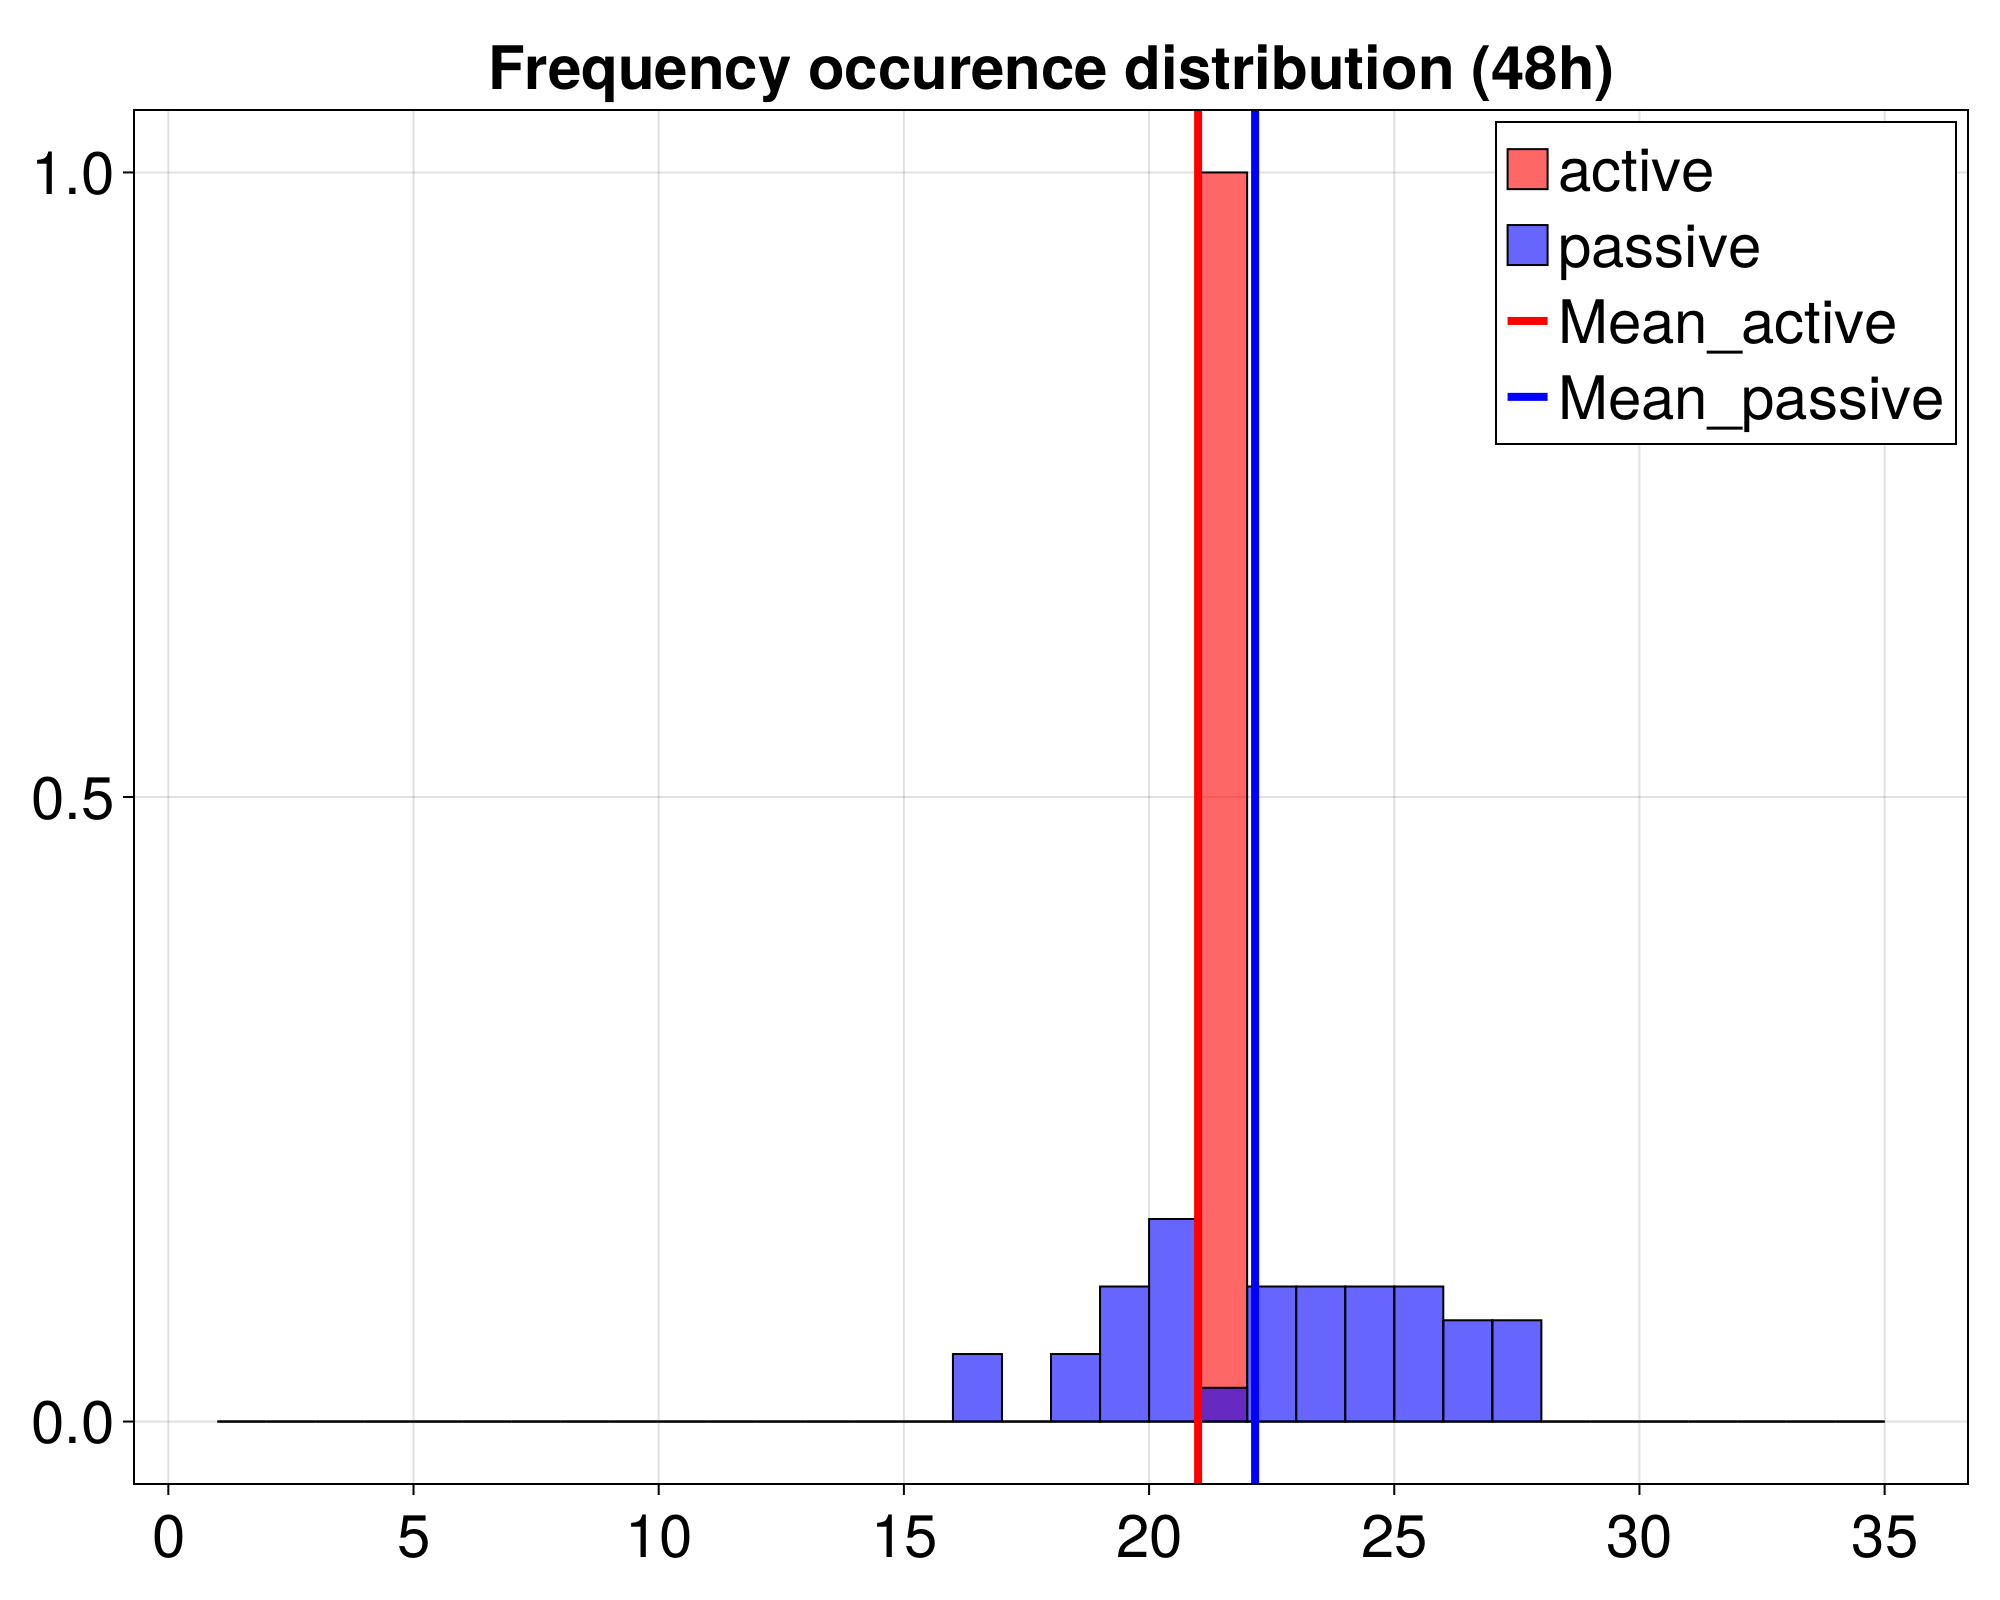

In [43]:
histo_data_a_vec = []
color_vec =[:green, :blue, :yellow, :orange, :purple, :black, :pink, :cyan, :magenta]



hans = Figure()
ax = Axis(hans[1,1])
#ylims!(ax,0,0.09)
histi = hist!(ax,histo_data_evo_active, bins = 1:35,strokewidth = 1, color = (:red, 0.6), label = "active",normalization = :pdf)
histi2 = hist!(ax,histo_data_evo_passive, bins = 1:35,strokewidth = 1, color = (:blue, 0.6), label = "passive",normalization = :pdf)
c = 1

"""
for (k,i) in pairs(groupby(fft_data_a_old,:data_set))
    push!(histo_data_a_vec, vcat(find_freq.(filter_fourier_beta.(i.abs_OG_n, b  =0.5))...))
    hist!(ax,histo_data_a_vec[end], bins = 1:40,strokewidth = 1, color = (color_vec[c], 0.3), label = mk_label(k.data_set),normalization = :pdf)
    c += 1
end
"""

vlines!(ax, mean(histo_data_evo_active), ymin = 0.00,ymax = 1.0, color = :red, linewidth = 4, label = "Mean_active")
vlines!(ax, mean(histo_data_evo_passive), ymin = 0.00,ymax = 1.0, color = :blue, linewidth = 4, label = "Mean_passive")
ax.title =  "Frequency occurence distribution (48h)"
ax.xticks = 0:5:35
axislegend( position = :rt,)

#save(joinpath(path,"frequ_dist_64.pdf"),hans)
hans

In [45]:
first(data_full)

DataFrameRow
 Row │ data_set                   colony             time   metric_cov         ⋯
     │ String                     String             Int64  Array…             ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 14_06_23_stacked_full_res  Kolonie-1 seg.tif      0  [0, 36, 51, 46, 47 ⋯
                                                               5 columns omitted

In [46]:
size_data = @chain data_full begin 
    groupby([:time])
    @combine(:abs_size = mean(sum.(:metric_OG)) ,:abs_size_normalized = mean(sum.(:metric_OG))./mean(:OG_size) ,:OG_size = mean(:OG_size) )
end

10×4 DataFrame
 Row │ time   abs_size  abs_size_normalized  OG_size 
     │ Int64  Float64   Float64              Float64 
─────┼───────────────────────────────────────────────
   1 │     0      0.0             0.0        20440.8
   2 │     3   2038.12            0.0709061  28744.0
   3 │     4   1678.83            0.110482   15195.5
   4 │    19  17691.8             0.615494   28744.0
   5 │    20  14938.2             0.983065   15195.5
   6 │    24  20884.1             1.02169    20440.8
   7 │    43  61265.8             2.13143    28744.0
   8 │    44  53696.8             3.53373    15195.5
   9 │    48  60257.4             2.80926    21449.6
  10 │    50  53456.6             3.16129    16909.8

In [47]:
cor_size = size_data.abs_size_normalized.+1

10-element Vector{Float64}:
 1.0
 1.070906102143056
 1.1104822699702763
 1.6154936682438072
 1.9830651618351924
 2.021687342957355
 3.1314274283328696
 4.5337325743367005
 3.8092555807715427
 4.161290084123065

In [48]:
ex(x,p) =(1+(p[1])).^x
p1 = [0.001]
fit2 = curve_fit(ex,size_data.time ,cor_size , p1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.029717008637752174], [0.0, 0.020920468685557747, 0.013790120494578506, 0.12888128118867392, -0.18685260696294792, -0.0022551601081524097, 0.3912194835070335, -0.9064031337899006, 0.2688507603555528, 0.1627958779003249], [0.0; 3.1809513536872336; … ; 190.09990625809866; 209.9647759720634;;], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

In [49]:
y2 = ex(size_data.time,fit2.param)
fit2.param

1-element Vector{Float64}:
 0.029717008637752174

In [50]:
1/fit2.param[1]

33.6507625040567

In [51]:
fit2.resid

10-element Vector{Float64}:
  0.0
  0.020920468685557747
  0.013790120494578506
  0.12888128118867392
 -0.18685260696294792
 -0.0022551601081524097
  0.3912194835070335
 -0.9064031337899006
  0.2688507603555528
  0.1627958779003249

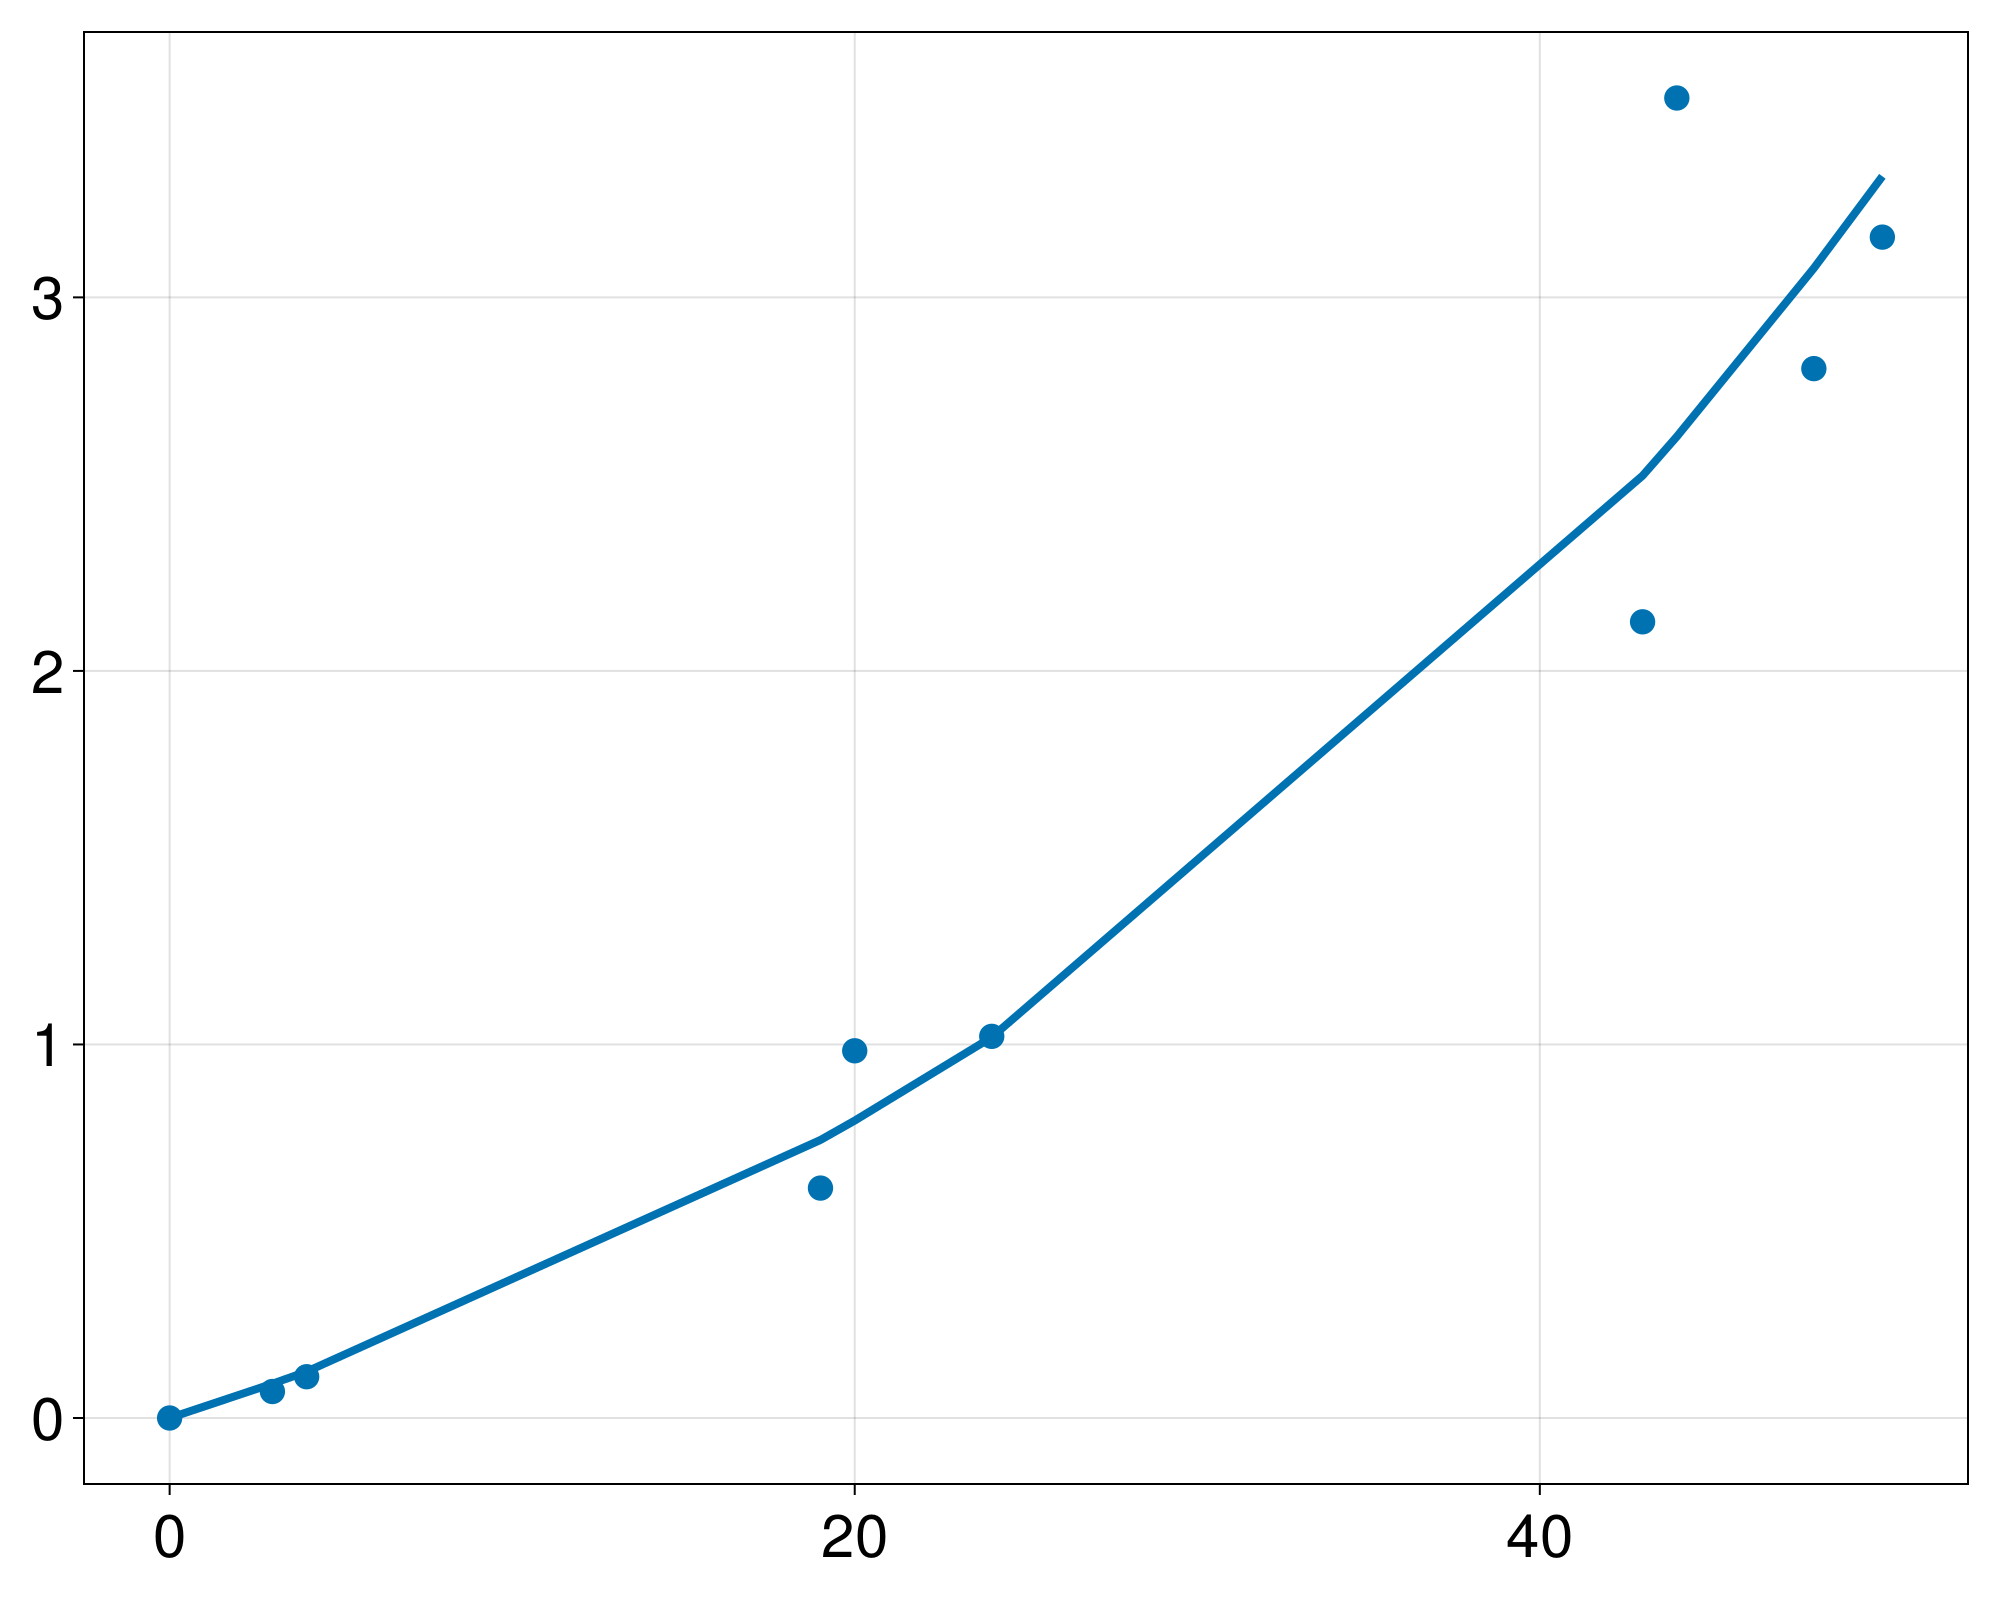

In [52]:
fig10 =scatter(size_data.time, size_data.abs_size_normalized)
lines!(fig10.axis, size_data.time, y2.-1)
fig10

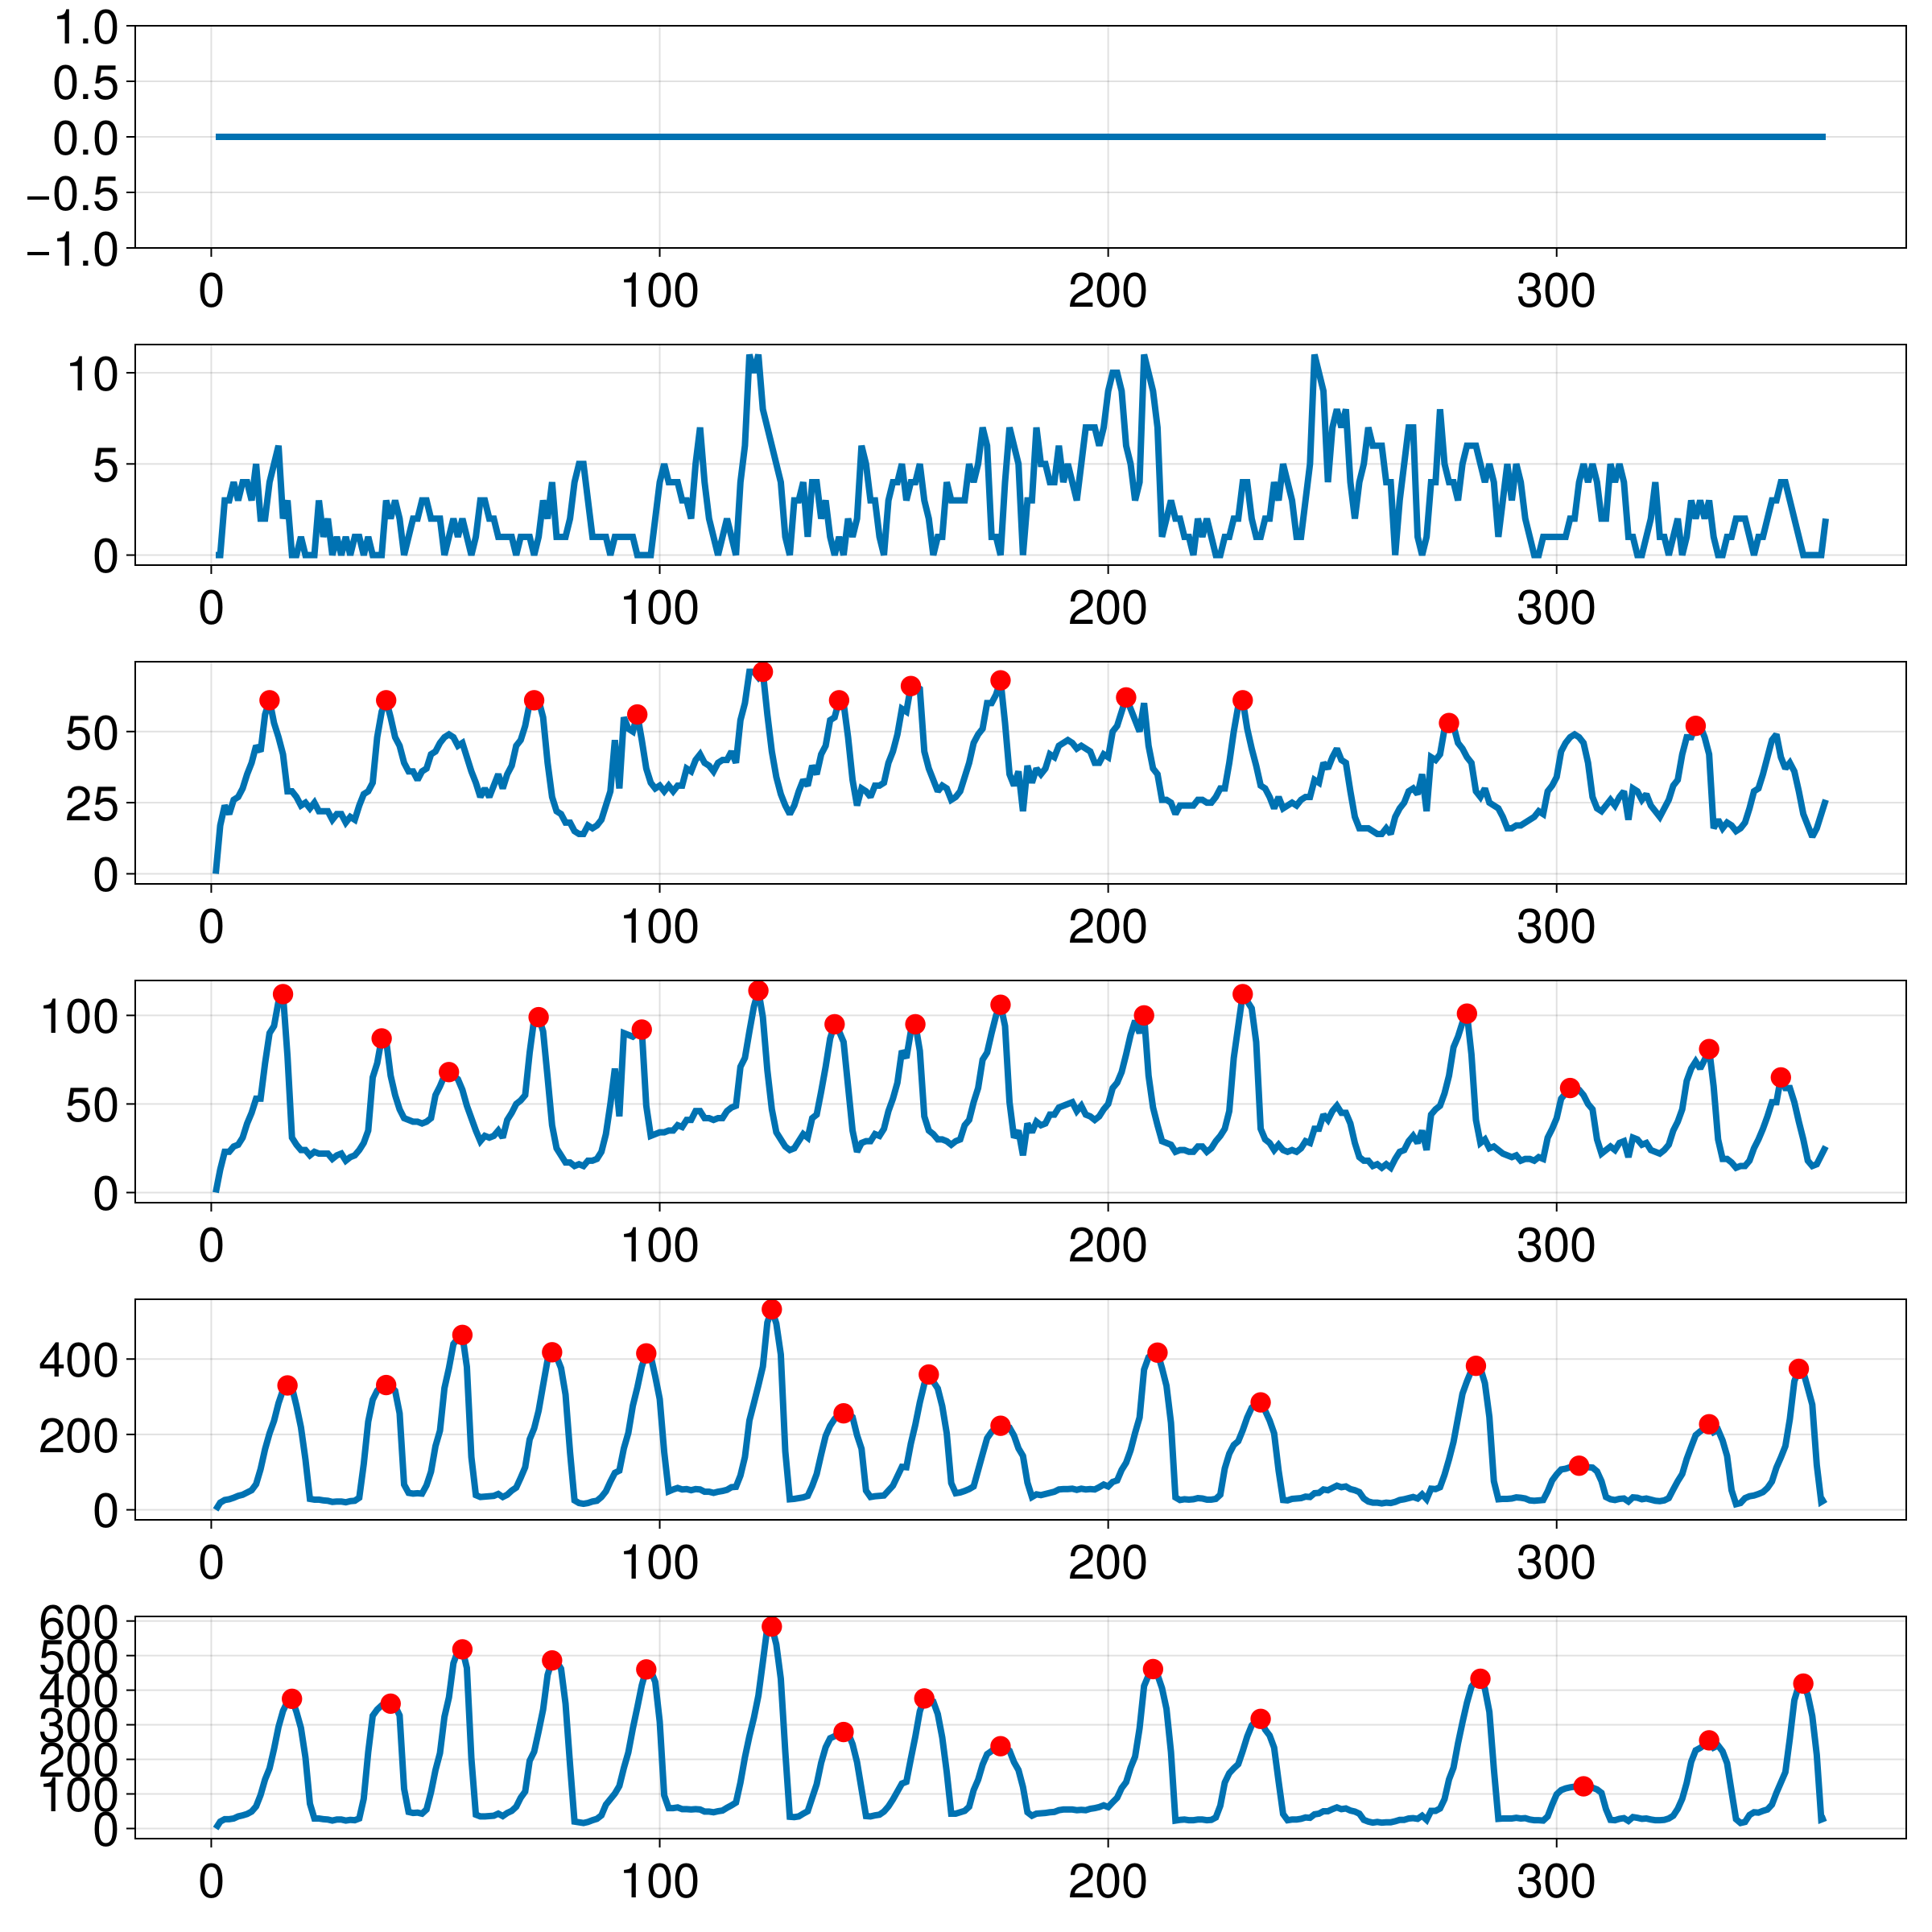

In [53]:
fig6 = Figure(size =(1200,1200))
for i in 1:6
    data1 = data_full.metric_OG[i+6];
    ax = CairoMakie.Axis(fig6[i,1])
    lines!(ax, data1)
    pkindices, properties = findpeaks1d(data1, prominence=0.6*mean(data1), distance = 4, height = 50)
    scatter!(ax, pkindices, data1[[pkindices...]],color = "red" )
end
fig6

In [54]:
peaks_full  = @chain data_full begin 
    @transform(:nr_peaks_OG = length.([findpeaks1d(i, prominence=0.4*mean(i), distance = 4, height = 40)[1] for i in :metric_OG])  )
end
first(peaks_full)

DataFrameRow
 Row │ data_set                   colony             time   metric_cov         ⋯
     │ String                     String             Int64  Array…             ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 14_06_23_stacked_full_res  Kolonie-1 seg.tif      0  [0, 36, 51, 46, 47 ⋯
                                                               6 columns omitted

In [55]:
peaks_over_time = @chain peaks_full begin
    groupby([:time])
    @combine(:peaks_mean = mean(:nr_peaks_OG), :peaks_stdd =std(:nr_peaks_OG) )
end


10×3 DataFrame
 Row │ time   peaks_mean  peaks_stdd 
     │ Int64  Float64     Float64    
─────┼───────────────────────────────
   1 │     0      0.0        0.0
   2 │     3      0.375      1.06066
   3 │     4      0.0        0.0
   4 │    19     11.875      4.01559
   5 │    20     14.8333     1.16905
   6 │    24     12.5        2.5579
   7 │    43     14.625      1.50594
   8 │    44     13.1667     1.94079
   9 │    48     13.0714     1.69812
  10 │    50      9.25       1.16496

In [56]:
peaks_over_time_all = @chain peaks_full begin
    groupby([:time,:data_set])
    @combine(:peaks_mean = mean(:nr_peaks_OG), :peaks_stdd =std(:nr_peaks_OG) )
end

18×4 DataFrame
 Row │ time   data_set                   peaks_mean  peaks_stdd 
     │ Int64  String                     Float64     Float64    
─────┼──────────────────────────────────────────────────────────
   1 │     0  14_06_23_stacked_full_res      0.0       0.0
   2 │     4  14_06_23_stacked_full_res      0.0       0.0
   3 │    20  14_06_23_stacked_full_res     14.8333    1.16905
   4 │    24  14_06_23_stacked_full_res     14.8333    0.983192
   5 │    44  14_06_23_stacked_full_res     13.1667    1.94079
   6 │    48  14_06_23_stacked_full_res     12.8333    2.31661
   7 │     0  17_05_23_stacked_full_res      0.0       0.0
   8 │    24  17_05_23_stacked_full_res     12.2857    2.33464
  ⋮  │   ⋮                ⋮                  ⋮           ⋮
  12 │    50  19_12_22_stacked_full_res      9.25      1.16496
  13 │     0  26_06_23_stacked_full_res      0.0       0.0
  14 │     3  26_06_23_stacked_full_res      0.375     1.06066
  15 │    19  26_06_23_stacked_full_res     11.875     4.01559
  16 │    24  26_06_23_stacked_full_res     13.875     2.16712
  17 │    43  26_06_23_stacked_full_res     14.625     1.50594
  18 │    48  26_06_23_stacked_full_res     14.625     1.50594
                                                  3 rows omitted

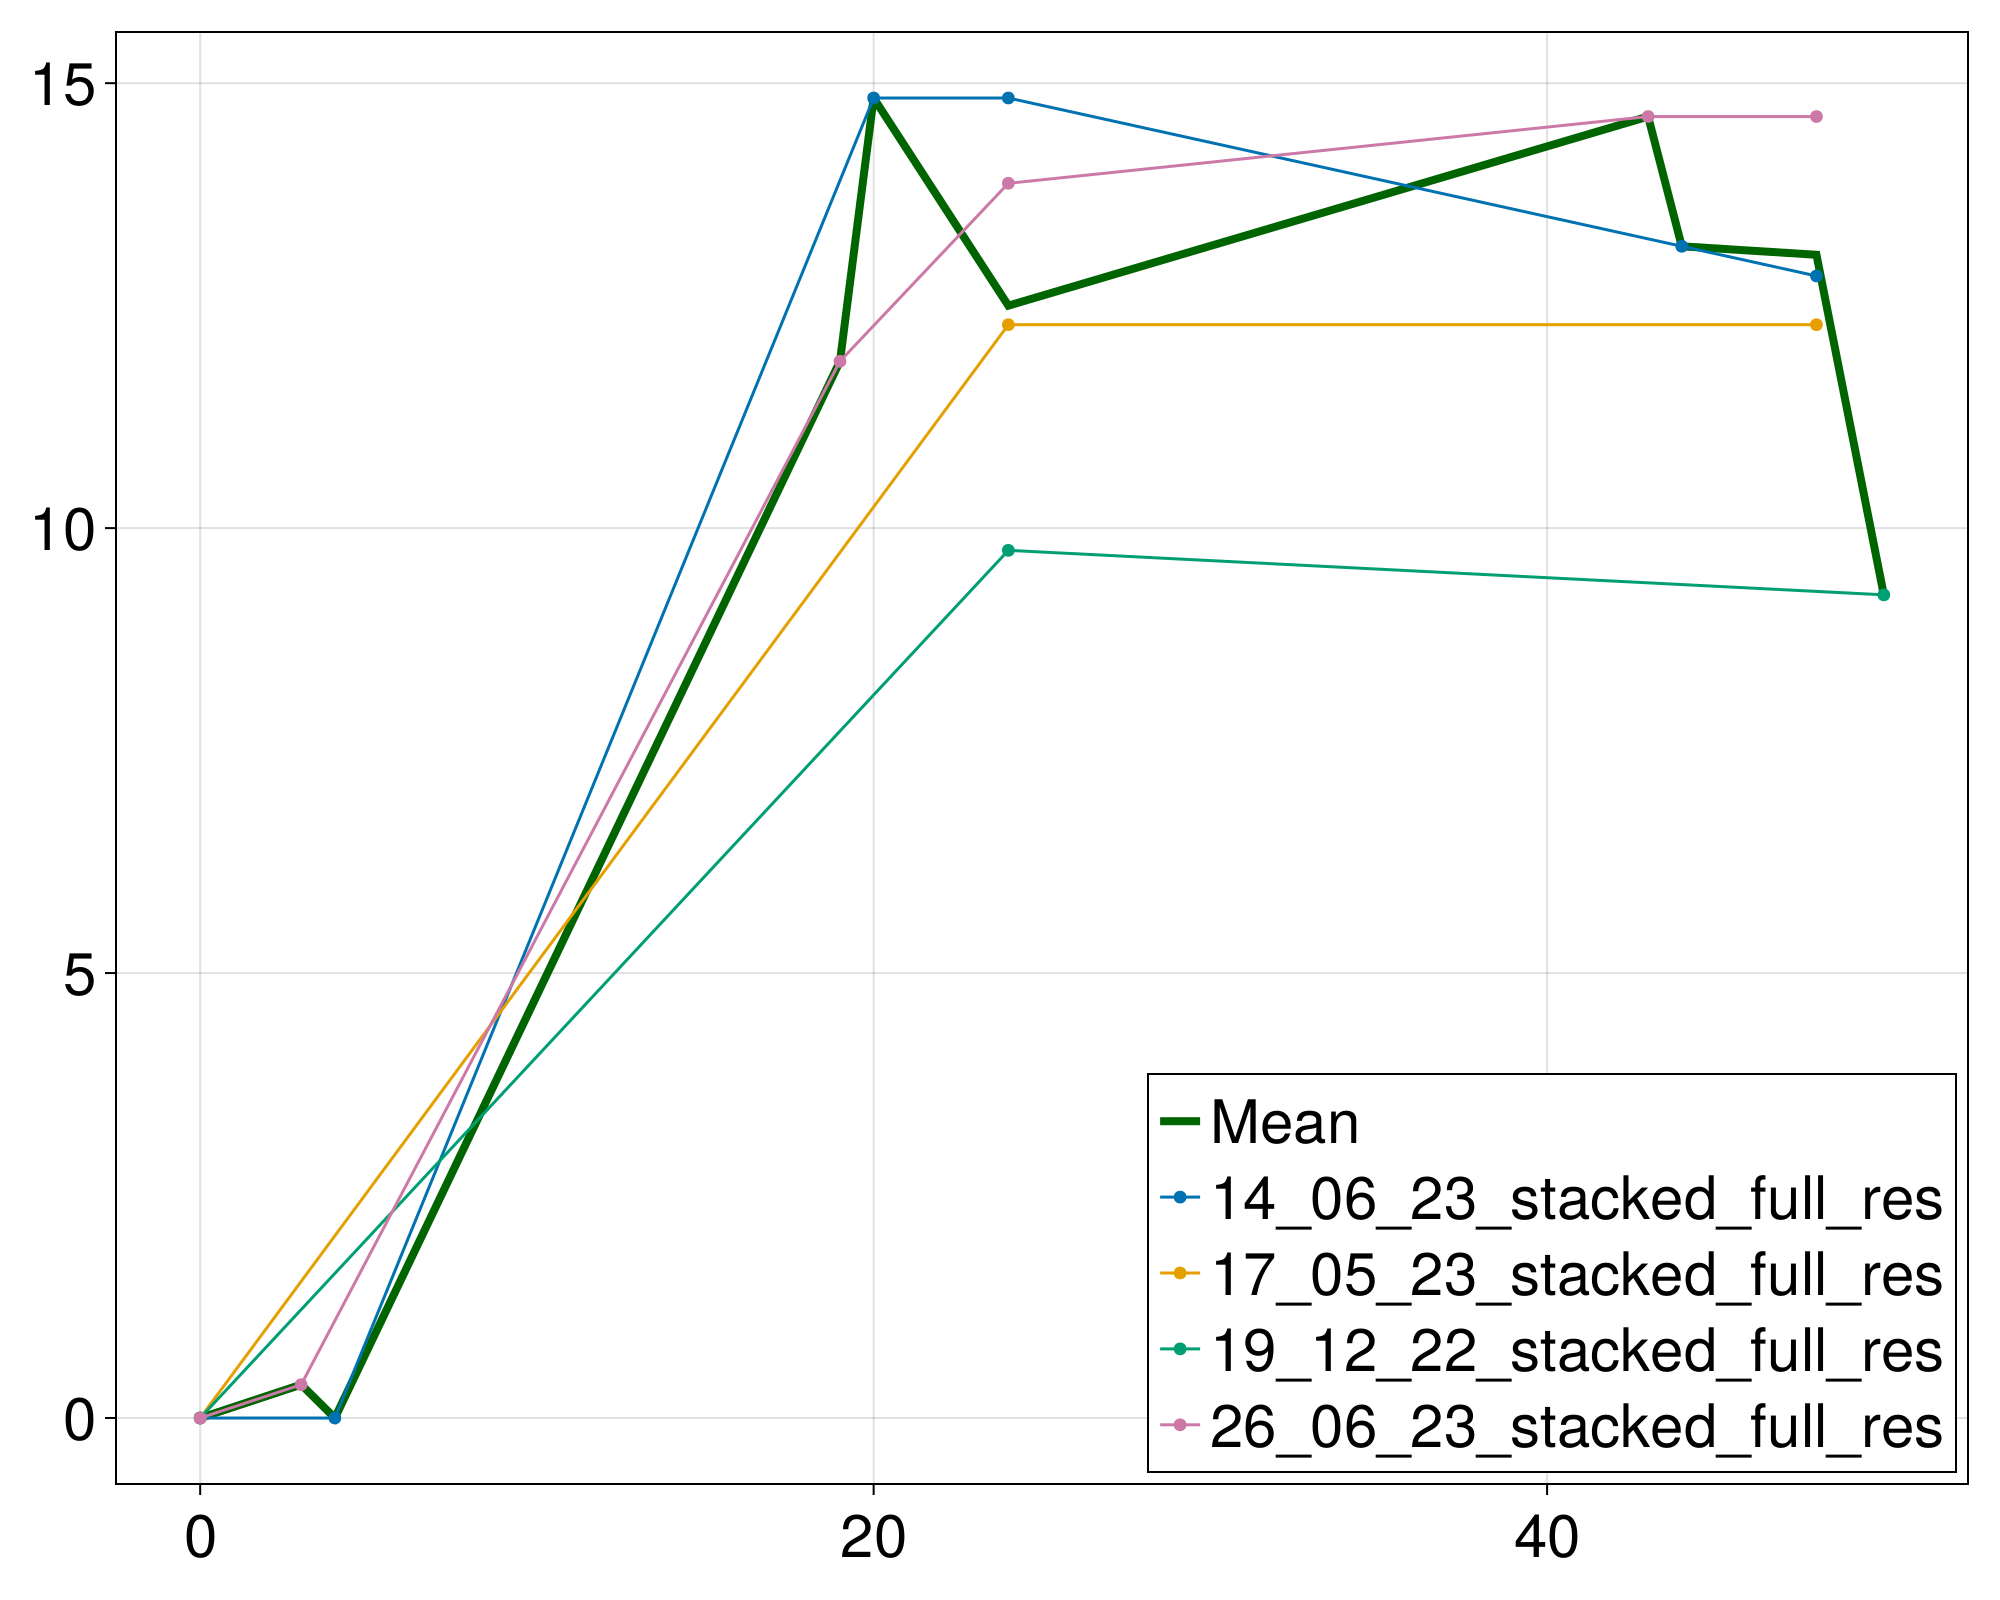

In [58]:
fig7 = lines(peaks_over_time.time,peaks_over_time.peaks_mean, color = "darkgreen", whiskerwidth = 10, label = "Mean")

for (k, i) in pairs(groupby(peaks_over_time_all,:data_set))
    scatterlines!(fig7.axis, i.time, i.peaks_mean, label = String(k.data_set))
end
axislegend(fig7.axis, position = :rb)
fig7


In [59]:
fIndex_fil = @chain df_f begin 
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:fil_OG = mean(sum.(:abs_OG)), :fil_cov = mean(sum.(:abs_cov)))
end

UndefVarError: UndefVarError: `df_f` not defined